## Разработка модели прогнозирования конечных свойств новых материалов (композиционных материалов)

#### Предметом настоящей работы является построение при помощи методов машинного обучения моделей прогнозирования следующих параметров: 
- «модуль упругости при растяжении»;
- «прочность при растяжении»;
- «соотношение матрица-наполнитель».

### Импорт внешних библиотек и модулей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow import keras 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten 
from pandas import read_excel, DataFrame, Series

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Activation, Dropout
from numpy.random import seed

### Загружаем данные из exel файлов

In [2]:
#Считываем данные в датасеты
df1 = pd.read_excel('Datasets\X_bp.xlsx')
df2 = pd.read_excel('Datasets\X_nup.xlsx')

In [3]:
#Посмотрим на первые 5 строк первого датасета
df1.head()

Unnamed: 0  Соотношение матрица-наполнитель  Плотность, кг/м3  \
0         0.0                         1.857143            2030.0   
1         1.0                         1.857143            2030.0   
2         2.0                         1.857143            2030.0   
3         3.0                         1.857143            2030.0   
4         4.0                         2.771331            2030.0   

   модуль упругости, ГПа  Количество отвердителя, м.%  \
0             738.736842                        30.00   
1             738.736842                        50.00   
2             738.736842                        49.90   
3             738.736842                       129.00   
4             753.000000                       111.86   

   Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                        22.267857                100.000000   
1                        23.750000                284.615385   
2                        33.000000                284.615385   
3                        21.250000                300.000000   
4                        22.267857                284.615385   

   Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                          210.0                                  70.0   
1                          210.0                                  70.0   
2                          210.0                                  70.0   
3                          210.0                                  70.0   
4                          210.0                                  70.0   

   Прочность при растяжении, МПа  Потребление смолы, г/м2  
0                         3000.0                    220.0  
1                         3000.0                    220.0  
2                         3000.0                    220.0  
3                         3000.0                    220.0  
4                         3000.0                    220.0

In [4]:
#Посмотрим на первые 5 строк второго датасета
df2.head()

Unnamed: 0  Угол нашивки, град  Шаг нашивки  Плотность нашивки
0         0.0                 0.0          4.0               57.0
1         1.0                 0.0          4.0               60.0
2         2.0                 0.0          4.0               70.0
3         3.0                 0.0          5.0               47.0
4         4.0                 0.0          5.0               57.0

### Объединияем датасеты в один

In [5]:
#Для объединения датасетов воспользуйтесь методом DataFrame.merge(), с параметром "inner"
df = df1.merge(df2, how='inner')

In [6]:
#Посмотрим на первые 5 строк объединенного датасета
df.head().T

0            1            2  \
Unnamed: 0                               0.000000     1.000000     2.000000   
Соотношение матрица-наполнитель          1.857143     1.857143     1.857143   
Плотность, кг/м3                      2030.000000  2030.000000  2030.000000   
модуль упругости, ГПа                  738.736842   738.736842   738.736842   
Количество отвердителя, м.%             30.000000    50.000000    49.900000   
Содержание эпоксидных групп,%_2         22.267857    23.750000    33.000000   
Температура вспышки, С_2               100.000000   284.615385   284.615385   
Поверхностная плотность, г/м2          210.000000   210.000000   210.000000   
Модуль упругости при растяжении, ГПа    70.000000    70.000000    70.000000   
Прочность при растяжении, МПа         3000.000000  3000.000000  3000.000000   
Потребление смолы, г/м2                220.000000   220.000000   220.000000   
Угол нашивки, град                       0.000000     0.000000     0.000000   
Шаг нашивки                              4.000000     4.000000     4.000000   
Плотность нашивки                       57.000000    60.000000    70.000000   

                                                3            4  
Unnamed: 0                               3.000000     4.000000  
Соотношение матрица-наполнитель          1.857143     2.771331  
Плотность, кг/м3                      2030.000000  2030.000000  
модуль упругости, ГПа                  738.736842   753.000000  
Количество отвердителя, м.%            129.000000   111.860000  
Содержание эпоксидных групп,%_2         21.250000    22.267857  
Температура вспышки, С_2               300.000000   284.615385  
Поверхностная плотность, г/м2          210.000000   210.000000  
Модуль упругости при растяжении, ГПа    70.000000    70.000000  
Прочность при растяжении, МПа         3000.000000  3000.000000  
Потребление смолы, г/м2                220.000000   220.000000  
Угол нашивки, град                       0.000000     0.000000  
Шаг нашивки                              5.000000     5.000000  
Плотность нашивки                       47.000000    57.000000

In [7]:
#Удалим из датасета колонку с индексом
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
#Посмотрим удалился ли первый столбец из датасета
df.head().T

0            1            2  \
Соотношение матрица-наполнитель          1.857143     1.857143     1.857143   
Плотность, кг/м3                      2030.000000  2030.000000  2030.000000   
модуль упругости, ГПа                  738.736842   738.736842   738.736842   
Количество отвердителя, м.%             30.000000    50.000000    49.900000   
Содержание эпоксидных групп,%_2         22.267857    23.750000    33.000000   
Температура вспышки, С_2               100.000000   284.615385   284.615385   
Поверхностная плотность, г/м2          210.000000   210.000000   210.000000   
Модуль упругости при растяжении, ГПа    70.000000    70.000000    70.000000   
Прочность при растяжении, МПа         3000.000000  3000.000000  3000.000000   
Потребление смолы, г/м2                220.000000   220.000000   220.000000   
Угол нашивки, град                       0.000000     0.000000     0.000000   
Шаг нашивки                              4.000000     4.000000     4.000000   
Плотность нашивки                       57.000000    60.000000    70.000000   

                                                3            4  
Соотношение матрица-наполнитель          1.857143     2.771331  
Плотность, кг/м3                      2030.000000  2030.000000  
модуль упругости, ГПа                  738.736842   753.000000  
Количество отвердителя, м.%            129.000000   111.860000  
Содержание эпоксидных групп,%_2         21.250000    22.267857  
Температура вспышки, С_2               300.000000   284.615385  
Поверхностная плотность, г/м2          210.000000   210.000000  
Модуль упругости при растяжении, ГПа    70.000000    70.000000  
Прочность при растяжении, МПа         3000.000000  3000.000000  
Потребление смолы, г/м2                220.000000   220.000000  
Угол нашивки, град                       0.000000     0.000000  
Шаг нашивки                              5.000000     5.000000  
Плотность нашивки                       47.000000    57.000000

In [9]:
#Просмотрим информацию о датесете (пропуски, тип данных)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг нашивки      

In [10]:
#Проверяем датасет на дубликаты
df.duplicated().sum()

0

In [11]:
#Сохраним объединенный датасет в папку Datasets
df.to_excel("Datasets\X_all.xlsx")

In [12]:
#Посмотрим на описательную статистику исходных данных (медиана, среднее значение и т.д.)
df.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1023.000000       1023.000000   
mean                          2.930366       1975.734888   
std                           0.913222         73.729231   
min                           0.389403       1731.764635   
25%                           2.317887       1924.155467   
50%                           2.906878       1977.621657   
75%                           3.552660       2021.374375   
max                           5.591742       2207.773481   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean              739.923233                   110.570769   
std               330.231581                    28.295911   
min                 2.436909                    17.740275   
25%               500.047452                    92.443497   
50%               739.664328                   110.564840   
75%               961.812526                   129.730366   
max              1911.536477                   198.953207   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                         22.244390                285.882151   
std                           2.406301                 40.943260   
min                          14.254985                100.000000   
25%                          20.608034                259.066528   
50%                          22.230744                285.896812   
75%                          23.961934                313.002106   
max                          33.000000                413.273418   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                      482.731833                             73.328571   
std                       281.314690                              3.118983   
min                         0.603740                             64.054061   
25%                       266.816645                             71.245018   
50%                       451.864365                             73.268805   
75%                       693.225017                             75.356612   
max                      1399.542362                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                     2466.922843               218.423144   
std                       485.628006                59.735931   
min                      1036.856605                33.803026   
25%                      2135.850448               179.627520   
50%                      2459.524526               219.198882   
75%                      2767.193119               257.481724   
max                      3848.436732               414.590628   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean            44.252199     6.899222          57.153929  
std             45.015793     2.563467          12.350969  
min              0.000000     0.000000           0.000000  
25%              0.000000     5.080033          49.799212  
50%              0.000000     6.916144          57.341920  
75%             90.000000     8.586293          64.944961  
max             90.000000    14.440522         103.988901

### Строим гистограммы распределения

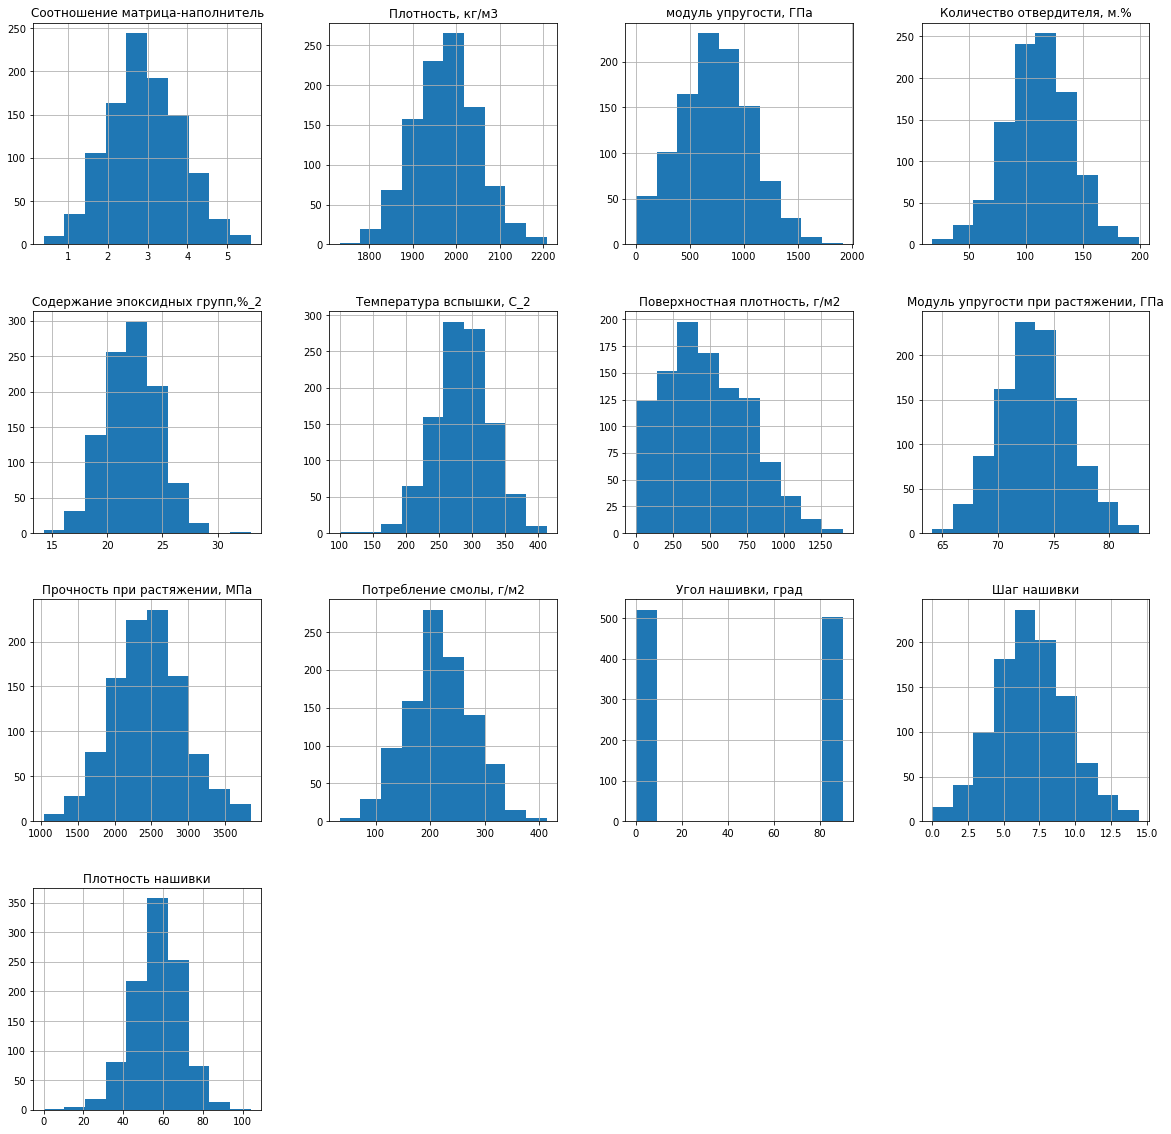

In [13]:
#Гистограммы без нормализации и исключения шумов
df.hist(figsize=(20,20))
plt.show()

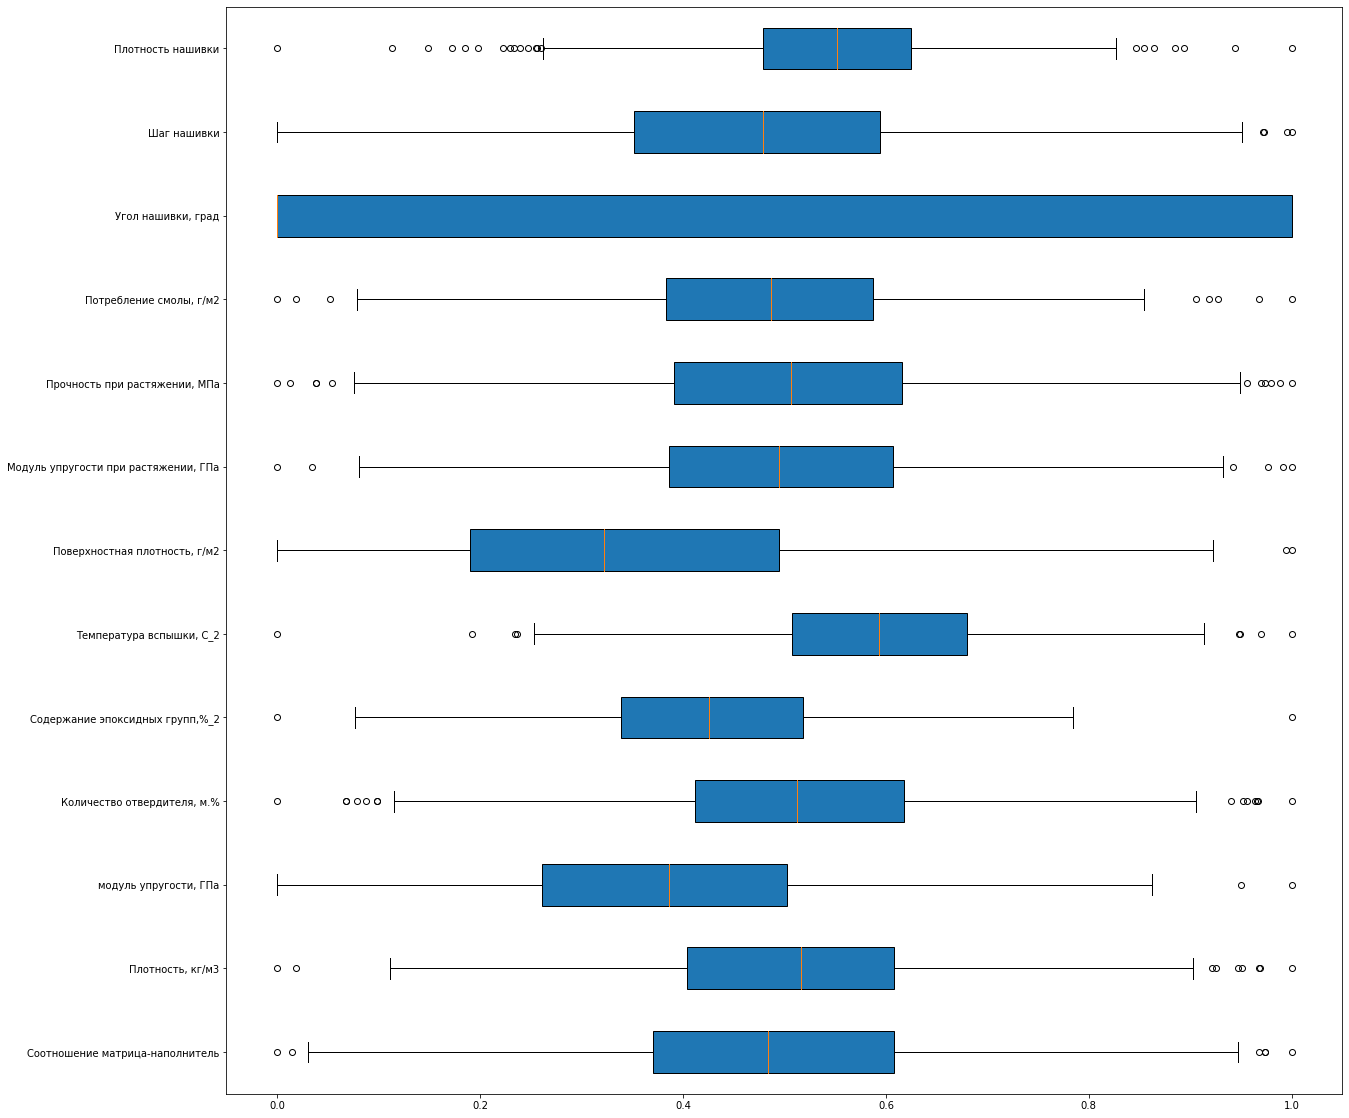

In [14]:
#Построим "ящики с усами", шкалы приведем к величинам в диапазоне [0,1], чтоб "ящики" были одного масштаба
scaler = MinMaxScaler()
scaler.fit(df)
plt.figure(figsize=(20, 20))
#Выводим "ящики"
plt.boxplot(pd.DataFrame(scaler.transform(df)), labels = df.columns, patch_artist=True, meanline=True,vert=False)
plt.show()

#### Видим, что выбросы есть во всех исходных данных, кроме "Угола нашивки"

In [15]:
#Создадим переменную со списком всех параметров, в которых есть выбросы
df.columns
column_list_drop = ['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Шаг нашивки', 'Плотность нашивки']

In [16]:
#Произведем замену выбросов на пустые значения
for i in column_list_drop:
    q75, q25 = np.percentile(df.loc[:,i],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    df.loc[df[i]<min,i] = np.nan
    df.loc[df[i]>max,i] = np.nan

In [17]:
#Посмотрим на сумму выбросов по каждому из столбцов
df.isnull().sum()

Соотношение матрица-наполнитель          6
Плотность, кг/м3                         9
модуль упругости, ГПа                    2
Количество отвердителя, м.%             14
Содержание эпоксидных групп,%_2          2
Температура вспышки, С_2                 8
Поверхностная плотность, г/м2            2
Модуль упругости при растяжении, ГПа     6
Прочность при растяжении, МПа           11
Потребление смолы, г/м2                  8
Угол нашивки, град                       0
Шаг нашивки                              4
Плотность нашивки                       21
dtype: int64

In [18]:
#Удалим строки, которые содержат выбросы (т.е. пустые значения)
df = df.dropna(axis=0)

In [19]:
#Повторно посмотрим на сумму выбросов по каждому из столбцов
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

In [20]:
#Просмотрим информацию о датесете после удаления пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 1 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       936 non-null    float64
 1   Плотность, кг/м3                      936 non-null    float64
 2   модуль упругости, ГПа                 936 non-null    float64
 3   Количество отвердителя, м.%           936 non-null    float64
 4   Содержание эпоксидных групп,%_2       936 non-null    float64
 5   Температура вспышки, С_2              936 non-null    float64
 6   Поверхностная плотность, г/м2         936 non-null    float64
 7   Модуль упругости при растяжении, ГПа  936 non-null    float64
 8   Прочность при растяжении, МПа         936 non-null    float64
 9   Потребление смолы, г/м2               936 non-null    float64
 10  Угол нашивки, град                    936 non-null    float64
 11  Шаг нашивки       

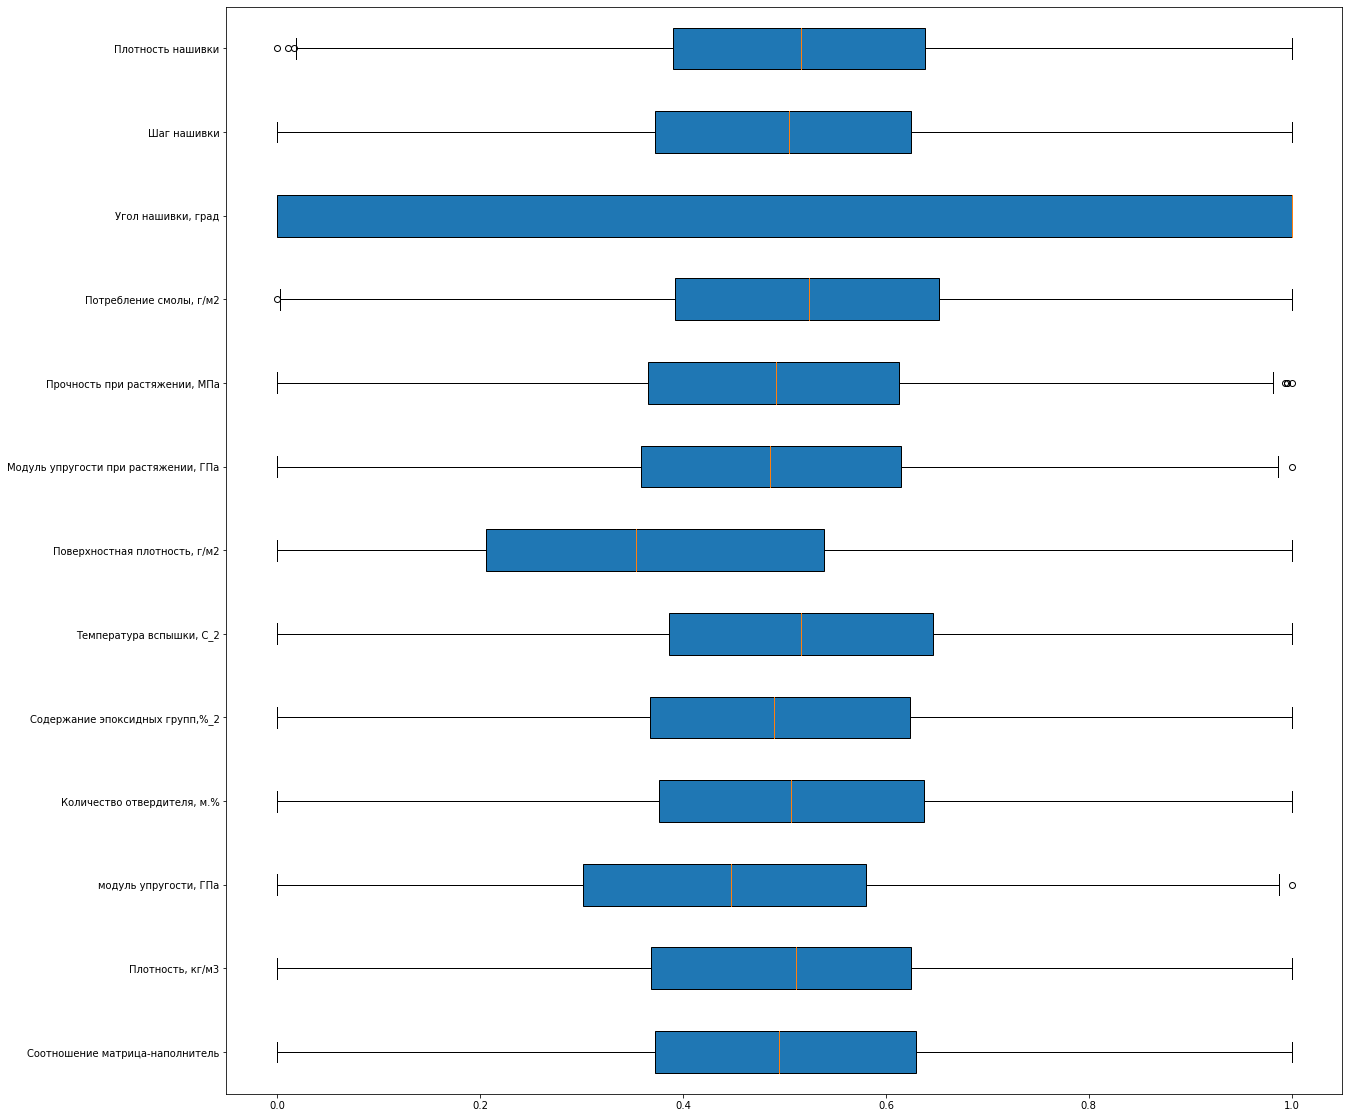

In [21]:
#Повторно построим на "ящики с усами"
scaler = MinMaxScaler()
scaler.fit(df)
plt.figure(figsize=(20, 20))
#Выводим "ящики"
plt.boxplot(pd.DataFrame(scaler.transform(df)), labels = df.columns, patch_artist=True, meanline=True,vert=False)
plt.show()

#### Видим, что выбросы остались в некоторых исходных данных.
#### Повторим удаление выбросов

In [22]:
#Произведем замену выбросов на пустые значения
for i in column_list_drop:
    q75, q25 = np.percentile(df.loc[:,i],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    df.loc[df[i]<min,i] = np.nan
    df.loc[df[i]>max,i] = np.nan

In [23]:
#Посмотрим на сумму выбросов по каждому из столбцов
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   1
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    1
Прочность при растяжении, МПа           4
Потребление смолы, г/м2                 1
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       3
dtype: int64

In [24]:
#Удалим строки, которые содержат выбросы (т.е. пустые значения)
df = df.dropna(axis=0)

In [25]:
#Повторно посмотрим на сумму выбросов по каждому из столбцов
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

In [26]:
#Просмотрим информацию о датесете после удаления пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926 entries, 1 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       926 non-null    float64
 1   Плотность, кг/м3                      926 non-null    float64
 2   модуль упругости, ГПа                 926 non-null    float64
 3   Количество отвердителя, м.%           926 non-null    float64
 4   Содержание эпоксидных групп,%_2       926 non-null    float64
 5   Температура вспышки, С_2              926 non-null    float64
 6   Поверхностная плотность, г/м2         926 non-null    float64
 7   Модуль упругости при растяжении, ГПа  926 non-null    float64
 8   Прочность при растяжении, МПа         926 non-null    float64
 9   Потребление смолы, г/м2               926 non-null    float64
 10  Угол нашивки, град                    926 non-null    float64
 11  Шаг нашивки       

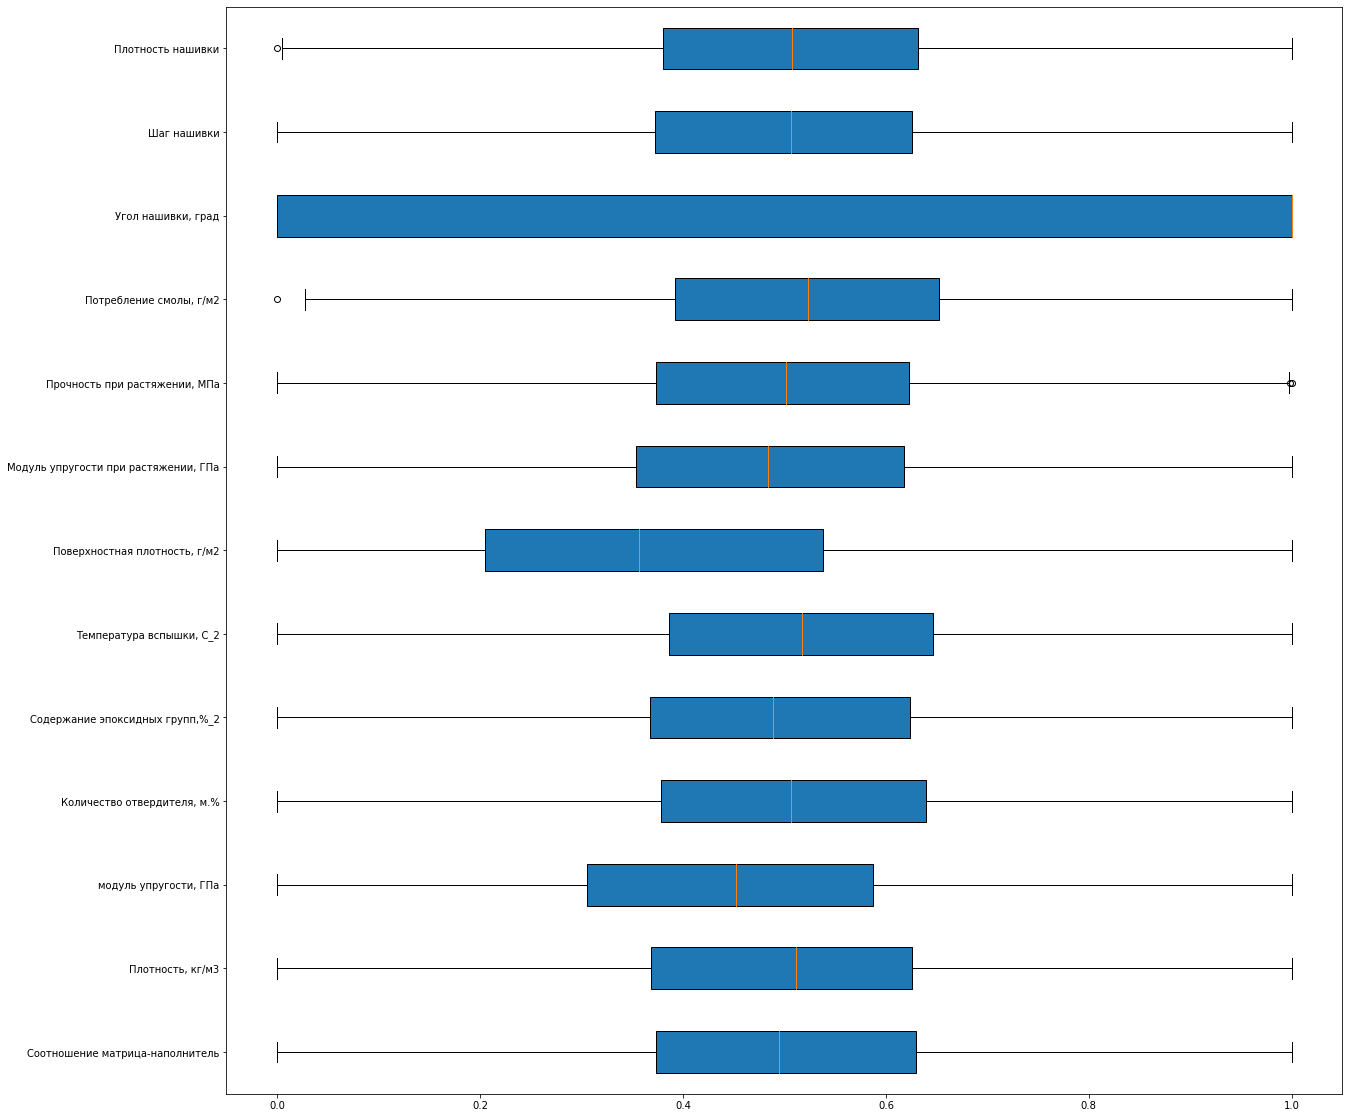

In [27]:
#Повторно построим на "ящики с усами"
scaler = MinMaxScaler()
scaler.fit(df)
plt.figure(figsize=(20, 20))
#Выводим "ящики"
plt.boxplot(pd.DataFrame(scaler.transform(df)), labels = df.columns, patch_artist=True, meanline=True,vert=False)
plt.show()

#### Видим, что выбросы остались в некоторых исходных данных.
#### Повторим удаление выбросов

In [28]:
#Произведем замену выбросов на пустые значения
for i in column_list_drop:
    q75, q25 = np.percentile(df.loc[:,i],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    df.loc[df[i]<min,i] = np.nan
    df.loc[df[i]>max,i] = np.nan

In [29]:
#Посмотрим на сумму выбросов по каждому из столбцов
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           2
Потребление смолы, г/м2                 1
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       1
dtype: int64

In [30]:
#Удалим строки, которые содержат выбросы (т.е. пустые значения)
df = df.dropna(axis=0)

In [31]:
#Повторно посмотрим на сумму выбросов по каждому из столбцов
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

In [32]:
#Просмотрим информацию о датесете после удаления пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 1 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       922 non-null    float64
 1   Плотность, кг/м3                      922 non-null    float64
 2   модуль упругости, ГПа                 922 non-null    float64
 3   Количество отвердителя, м.%           922 non-null    float64
 4   Содержание эпоксидных групп,%_2       922 non-null    float64
 5   Температура вспышки, С_2              922 non-null    float64
 6   Поверхностная плотность, г/м2         922 non-null    float64
 7   Модуль упругости при растяжении, ГПа  922 non-null    float64
 8   Прочность при растяжении, МПа         922 non-null    float64
 9   Потребление смолы, г/м2               922 non-null    float64
 10  Угол нашивки, град                    922 non-null    float64
 11  Шаг нашивки       

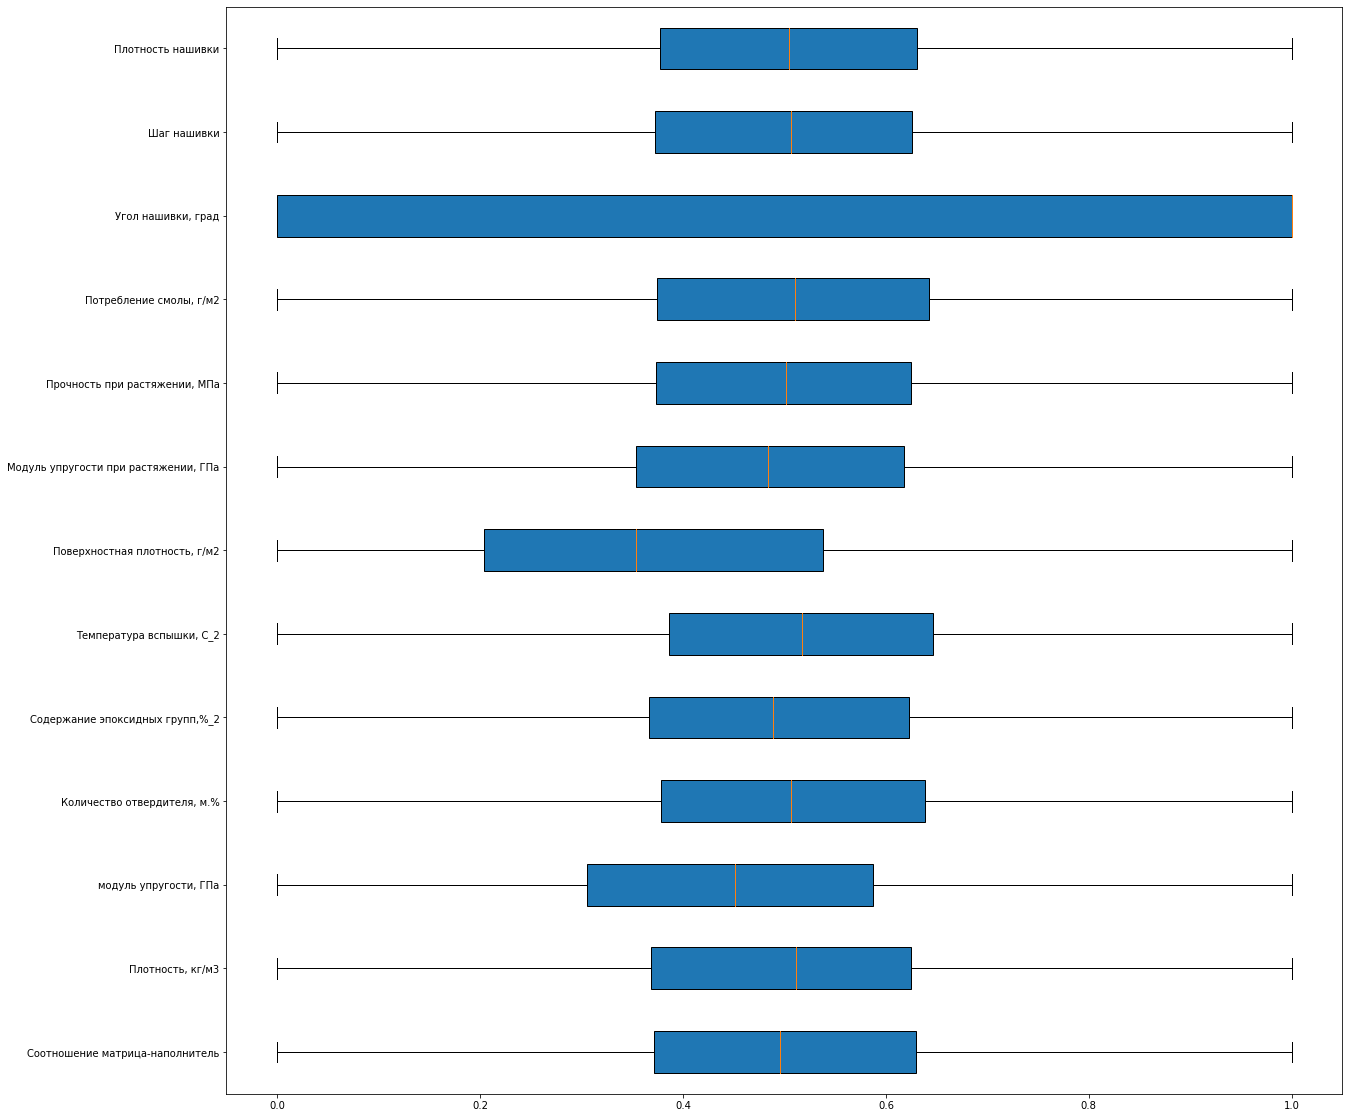

In [33]:
#Повторно построим на "ящики с усами"
scaler = MinMaxScaler()
scaler.fit(df)
plt.figure(figsize=(20, 20))
#Выводим "ящики"
plt.boxplot(pd.DataFrame(scaler.transform(df)), labels = df.columns, patch_artist=True, meanline=True,vert=False)
plt.show()

#### Видим, что выбросов не остались.

In [34]:
#Сохраним очищенный от выбросов датасет в папку Datasets
#df.to_csv('Datasets\X_clear.csv', encoding = 'cp1251' )
df.to_excel("Datasets\X_clear.xlsx")

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 1 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       922 non-null    float64
 1   Плотность, кг/м3                      922 non-null    float64
 2   модуль упругости, ГПа                 922 non-null    float64
 3   Количество отвердителя, м.%           922 non-null    float64
 4   Содержание эпоксидных групп,%_2       922 non-null    float64
 5   Температура вспышки, С_2              922 non-null    float64
 6   Поверхностная плотность, г/м2         922 non-null    float64
 7   Модуль упругости при растяжении, ГПа  922 non-null    float64
 8   Прочность при растяжении, МПа         922 non-null    float64
 9   Потребление смолы, г/м2               922 non-null    float64
 10  Угол нашивки, град                    922 non-null    float64
 11  Шаг нашивки       

In [36]:
#Посмотрим на корреляции между параметрами
df.corr()

Соотношение матрица-наполнитель  \
Соотношение матрица-наполнитель                              1.000000   
Плотность, кг/м3                                             0.007996   
модуль упругости, ГПа                                        0.051643   
Количество отвердителя, м.%                                  0.001353   
Содержание эпоксидных групп,%_2                              0.021982   
Температура вспышки, С_2                                    -0.010565   
Поверхностная плотность, г/м2                                0.011910   
Модуль упругости при растяжении, ГПа                        -0.024316   
Прочность при растяжении, МПа                                0.019141   
Потребление смолы, г/м2                                      0.076857   
Угол нашивки, град                                          -0.032144   
Шаг нашивки                                                  0.039924   
Плотность нашивки                                            0.047835   

                                      Плотность, кг/м3  модуль упругости, ГПа  \
Соотношение матрица-наполнитель               0.007996               0.051643   
Плотность, кг/м3                              1.000000              -0.001416   
модуль упругости, ГПа                        -0.001416               1.000000   
Количество отвердителя, м.%                  -0.048938               0.044550   
Содержание эпоксидных групп,%_2               0.004568              -0.001442   
Температура вспышки, С_2                     -0.021256               0.037622   
Поверхностная плотность, г/м2                 0.061496              -0.007805   
Модуль упругости при растяжении, ГПа         -0.015597               0.020063   
Прочность при растяжении, МПа                -0.079188               0.031041   
Потребление смолы, г/м2                      -0.009609               0.008368   
Угол нашивки, град                           -0.052993              -0.031490   
Шаг нашивки                                  -0.048648               0.010238   
Плотность нашивки                             0.086460               0.078810   

                                      Количество отвердителя, м.%  \
Соотношение матрица-наполнитель                          0.001353   
Плотность, кг/м3                                        -0.048938   
модуль упругости, ГПа                                    0.044550   
Количество отвердителя, м.%                              1.000000   
Содержание эпоксидных групп,%_2                          0.011429   
Температура вспышки, С_2                                 0.070623   
Поверхностная плотность, г/м2                            0.038762   
Модуль упругости при растяжении, ГПа                    -0.057026   
Прочность при растяжении, МПа                           -0.065711   
Потребление смолы, г/м2                                 -0.014827   
Угол нашивки, град                                       0.034103   
Шаг нашивки                                             -0.017394   
Плотность нашивки                                        0.007981   

                                      Содержание эпоксидных групп,%_2  \
Соотношение матрица-наполнитель                              0.021982   
Плотность, кг/м3                                             0.004568   
модуль упругости, ГПа                                       -0.001442   
Количество отвердителя, м.%                                  0.011429   
Содержание эпоксидных групп,%_2                              1.000000   
Температура вспышки, С_2                                    -0.025315   
Поверхностная плотность, г/м2                               -0.015844   
Модуль упругости при растяжении, ГПа                         0.053887   
Прочность при растяжении, МПа                               -0.013099   
Потребление смолы, г/м2                                      0.010808   
Угол нашивки, град                                           0.034520   
Шаг нашивки                          

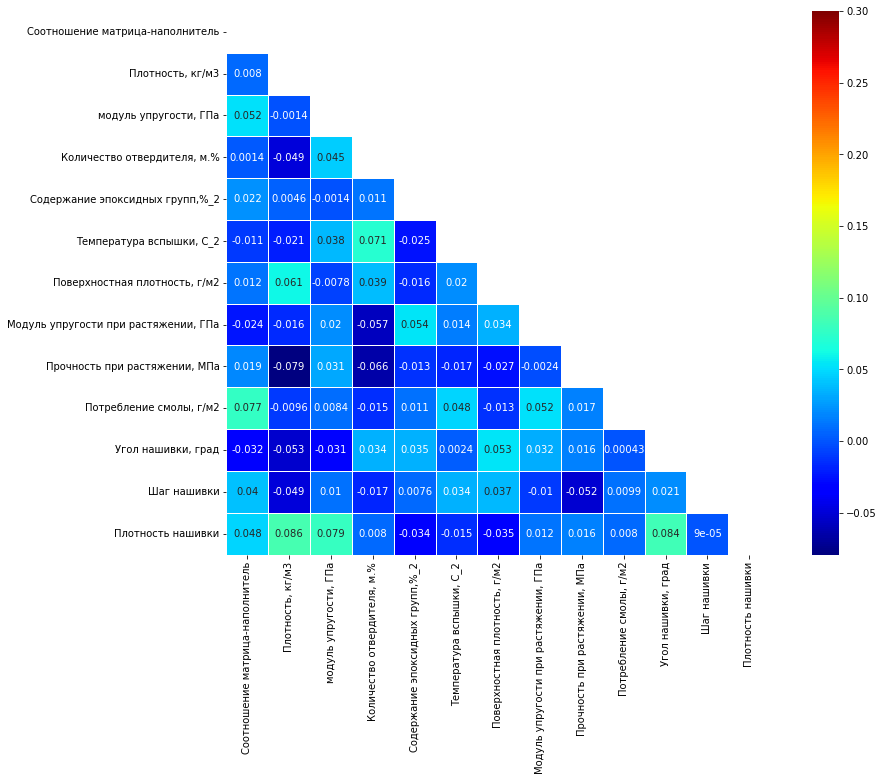

In [37]:
#Визуализаруем данные корреляции
len(df)
f, ax = plt.subplots(figsize=(15, 10))
corr = np.round_(df.corr(), decimals=5)
sns.heatmap(corr,annot=True,cmap='jet',square=True,linewidths=1,vmax=.3, mask = np.triu(df.corr()));

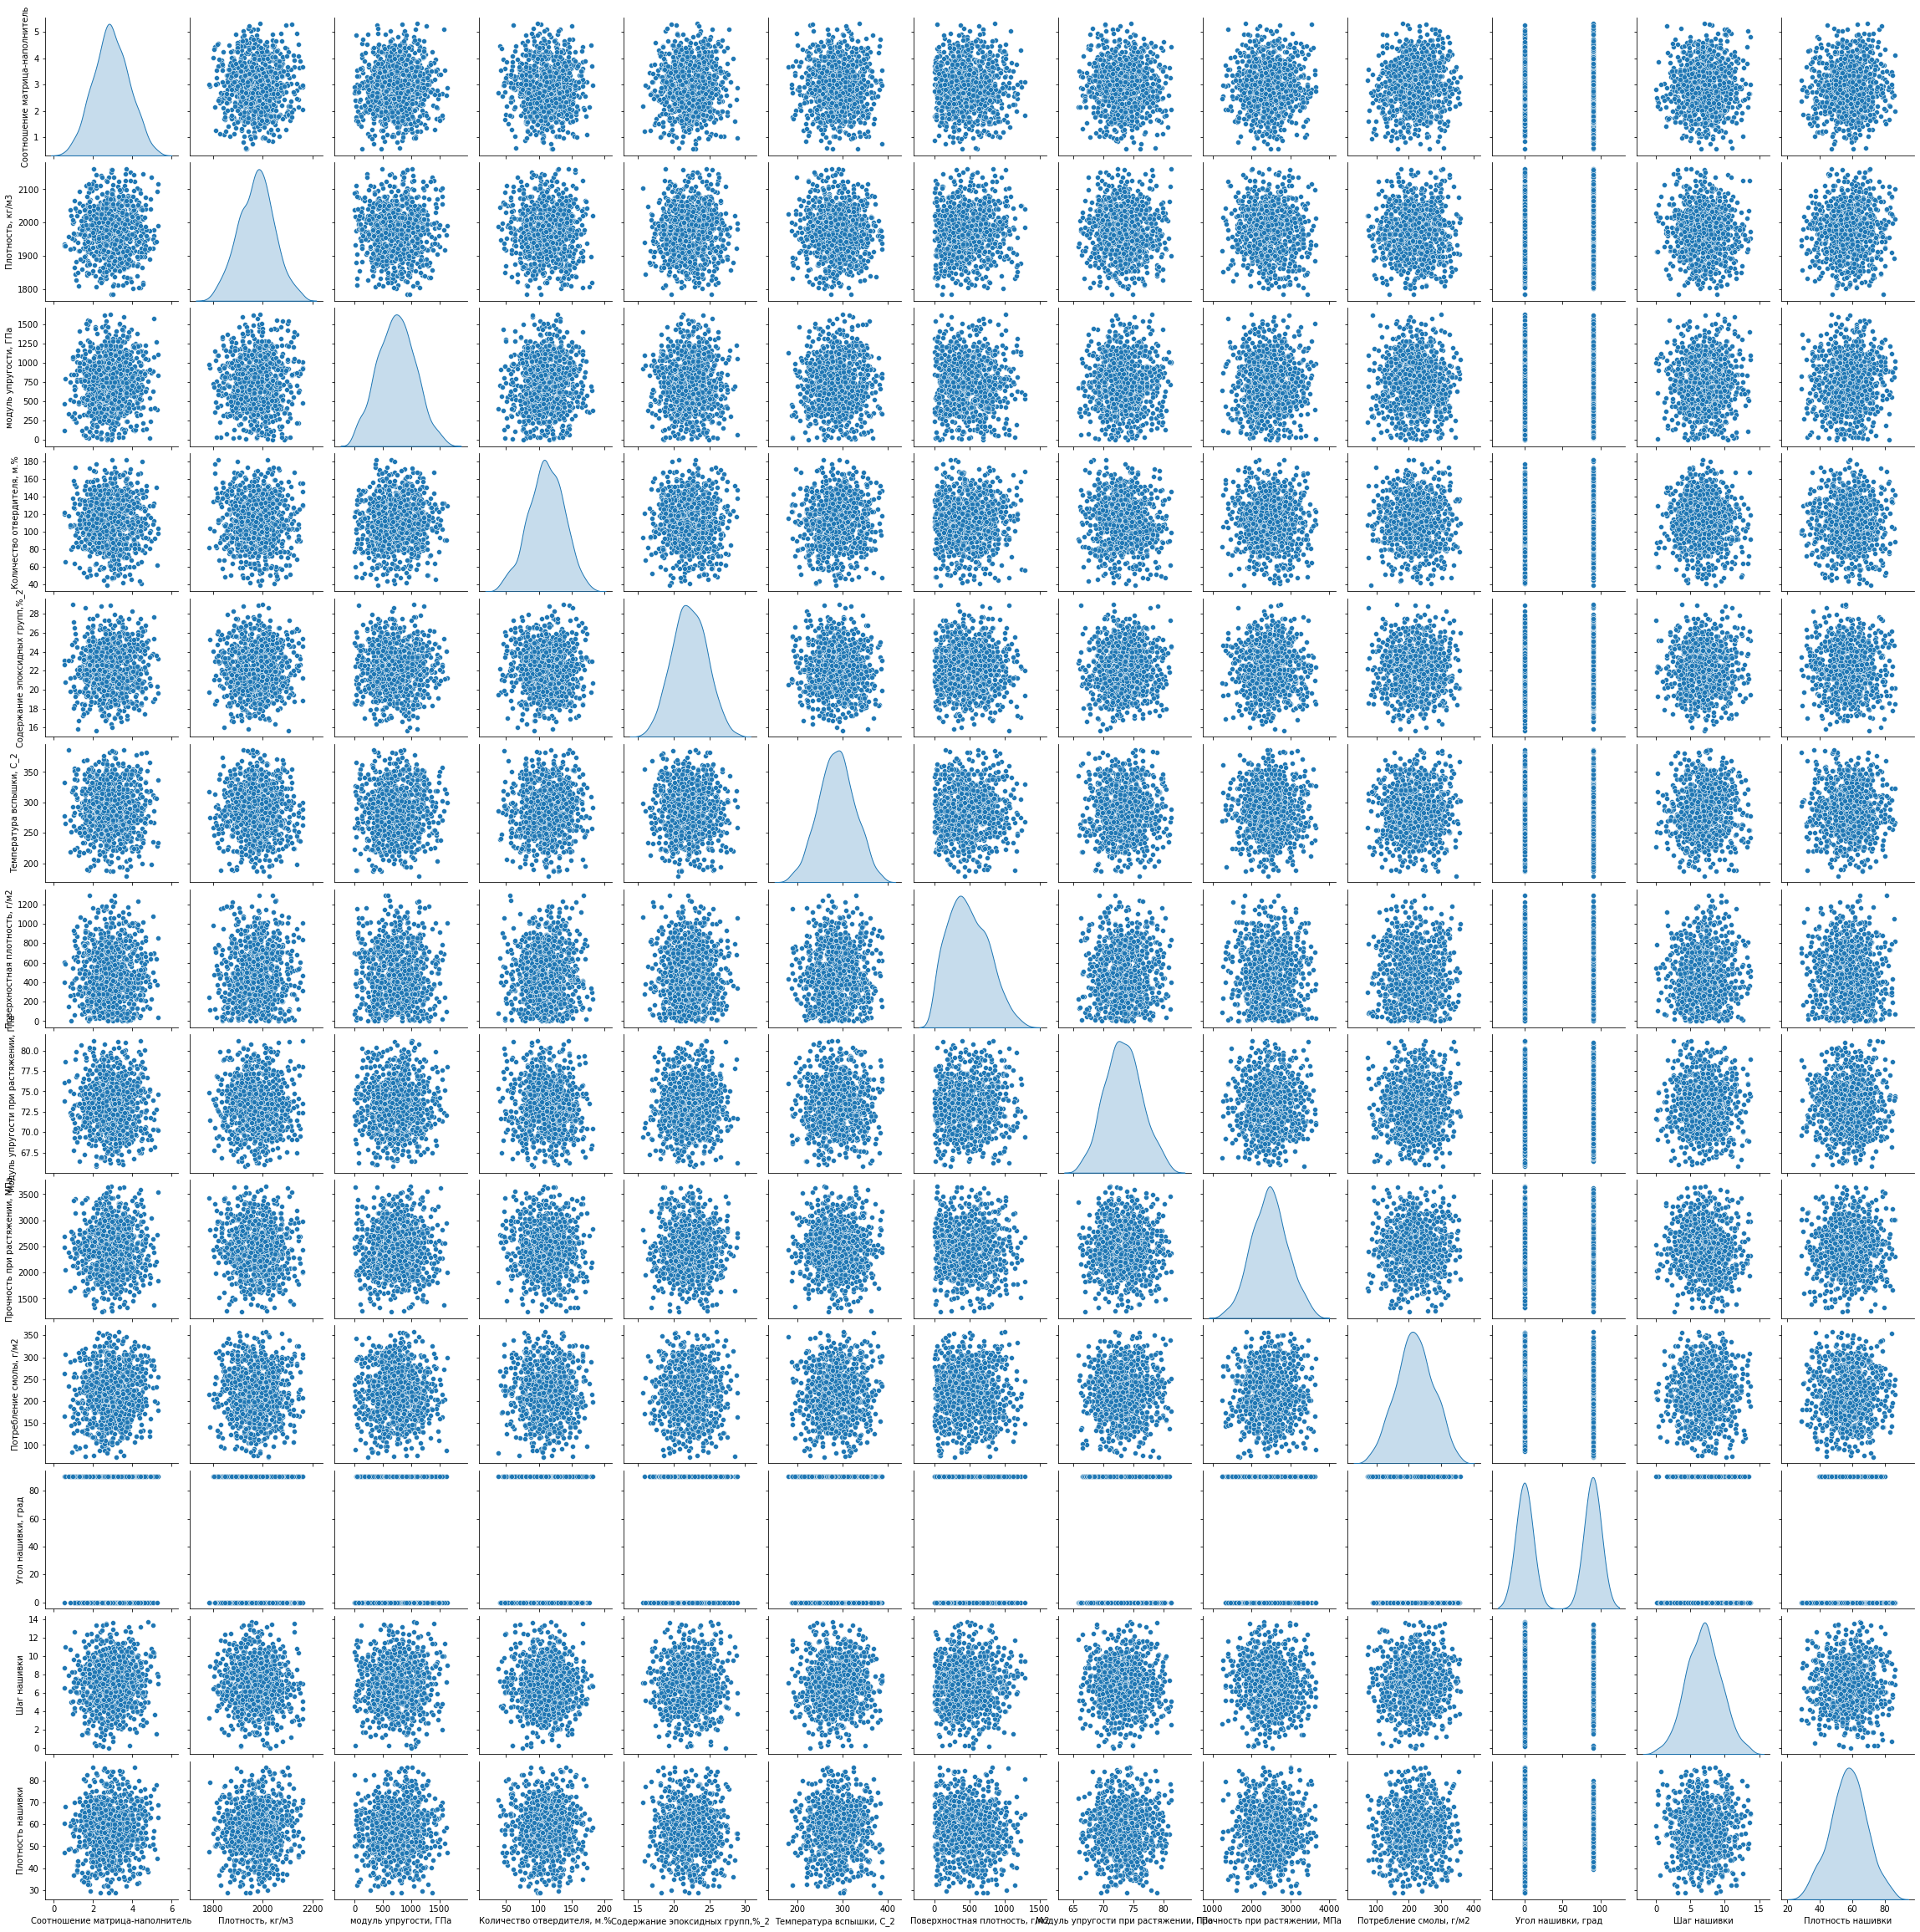

In [38]:
#Построим парные графики рассеяния точек (вариант 1)
sns.pairplot(df, diag_kind='kde')
plt.show()

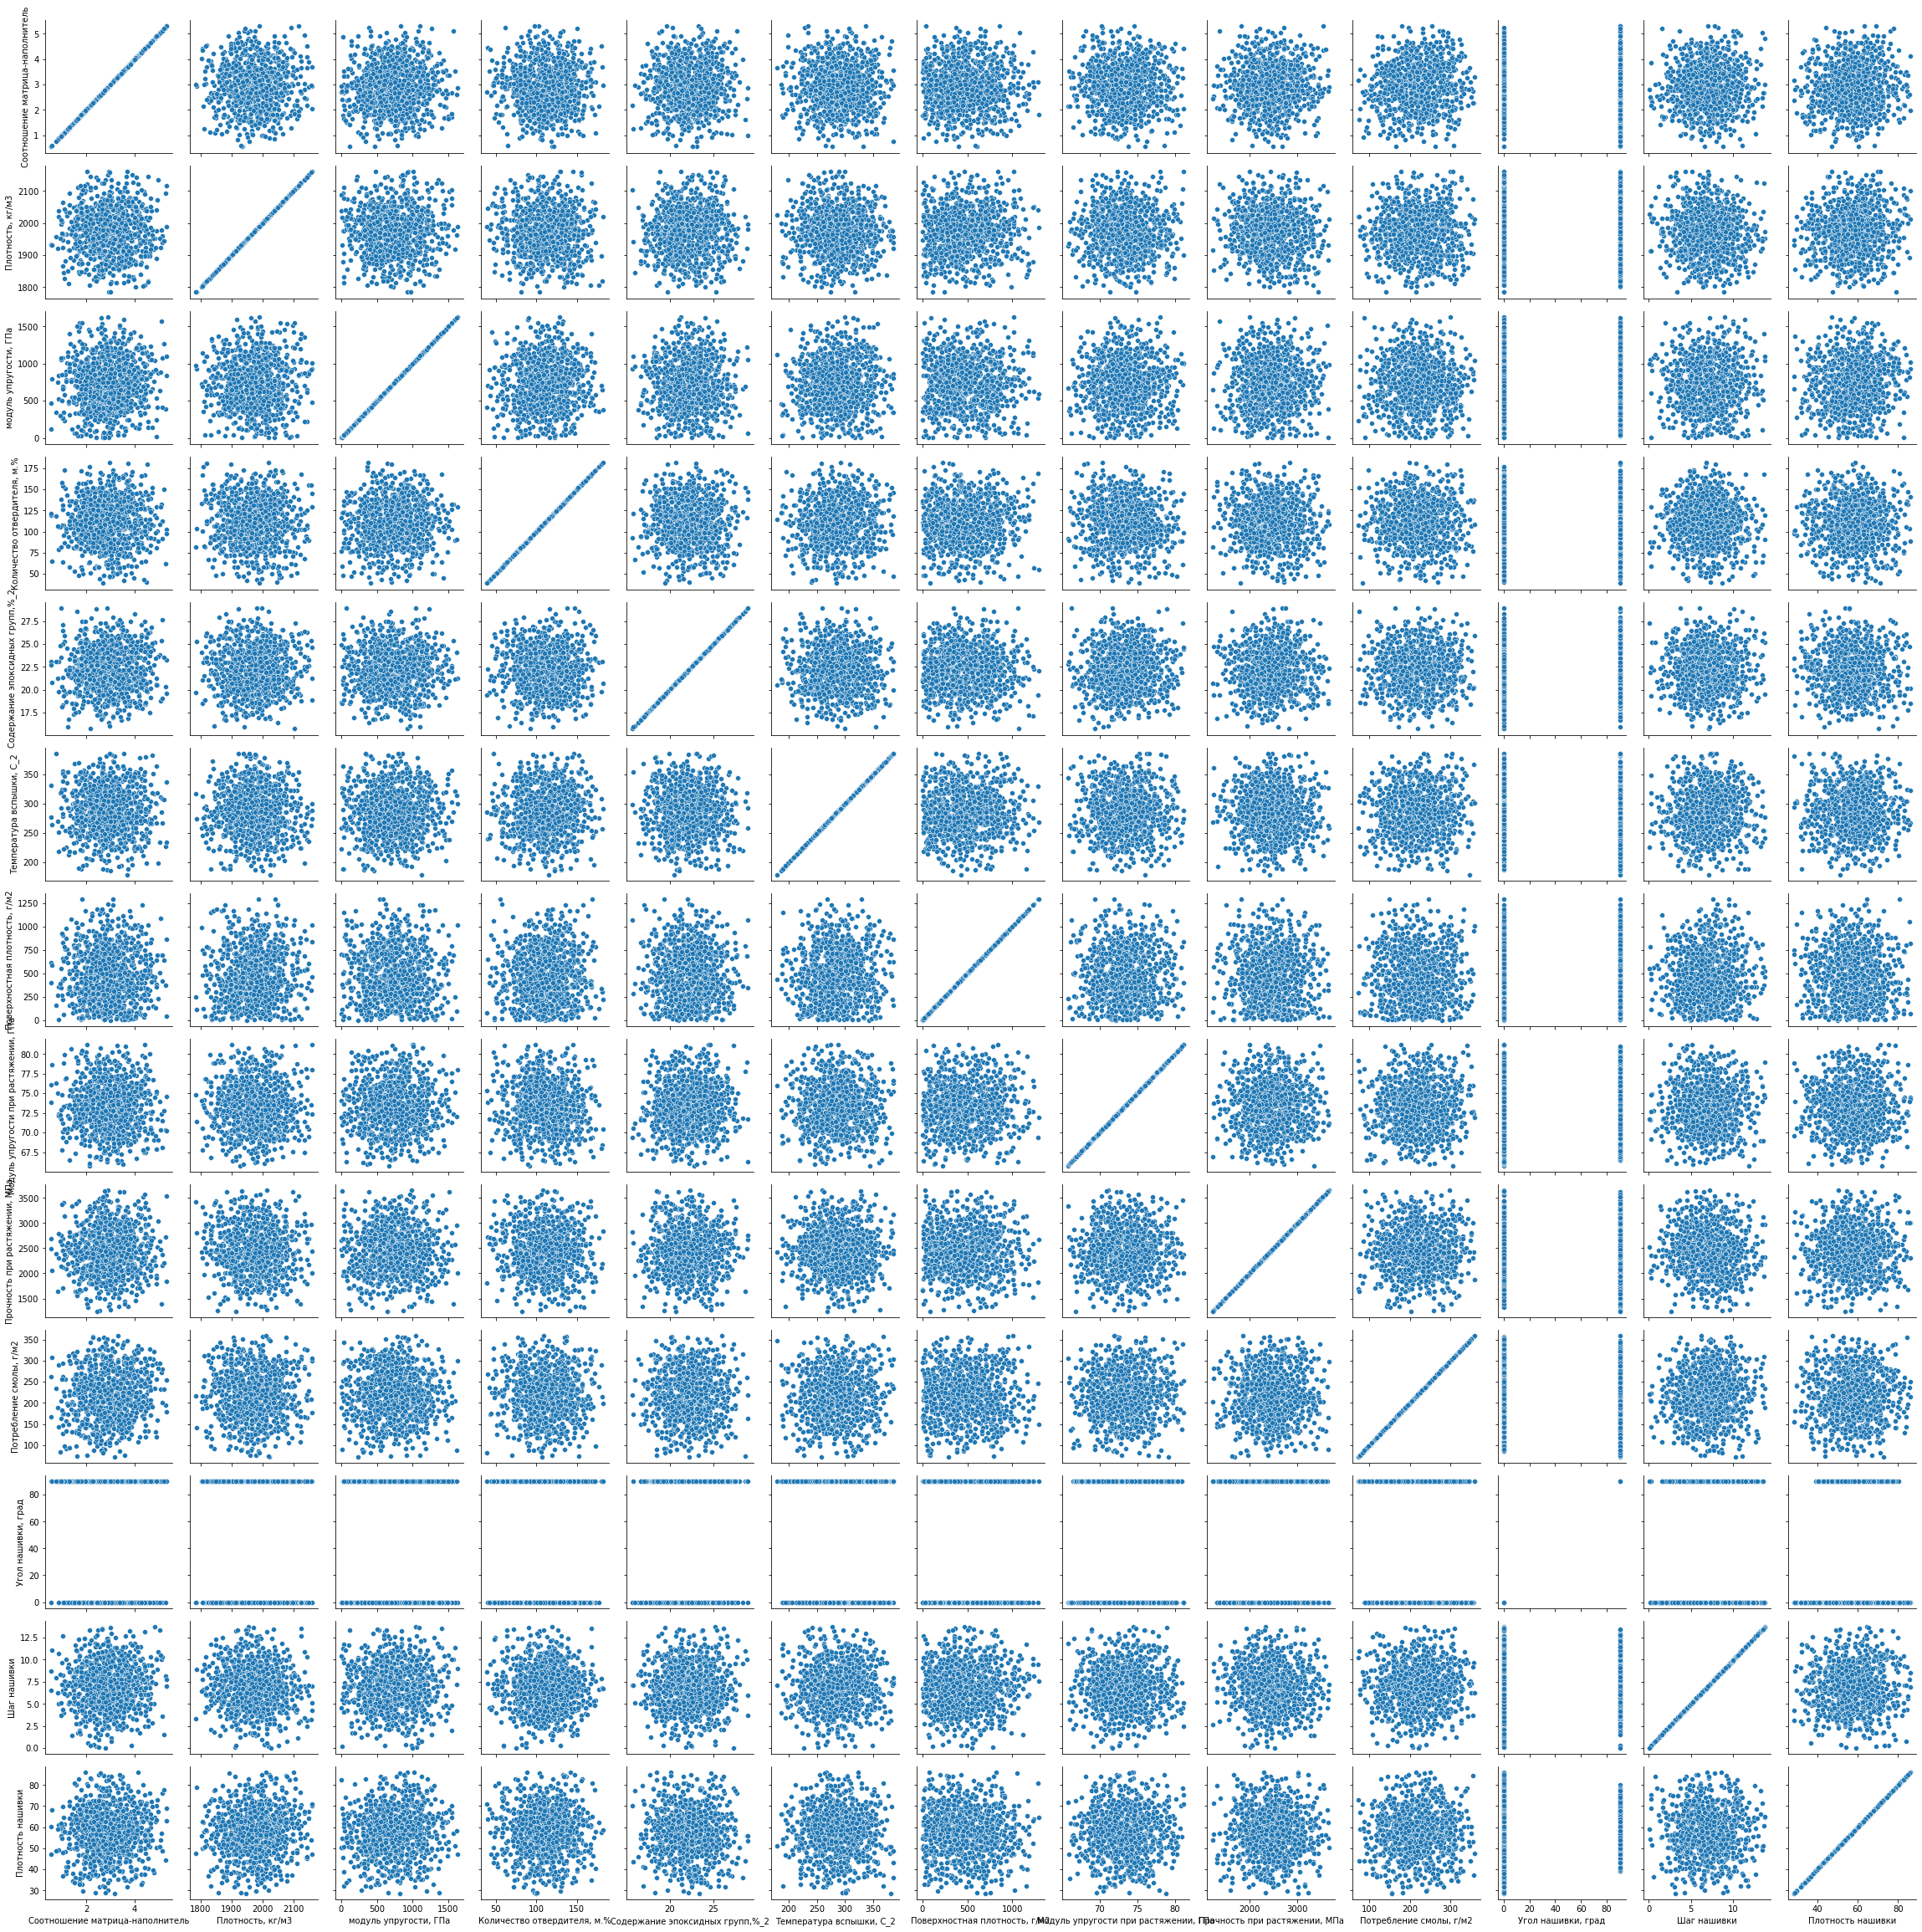

In [39]:
#Построим парные графики рассеяния точек (вариант 2)
col = df.columns
p = sns.PairGrid(df[col])
p.map(sns.scatterplot)

In [40]:
df_norm = df.copy()

In [41]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 1 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       922 non-null    float64
 1   Плотность, кг/м3                      922 non-null    float64
 2   модуль упругости, ГПа                 922 non-null    float64
 3   Количество отвердителя, м.%           922 non-null    float64
 4   Содержание эпоксидных групп,%_2       922 non-null    float64
 5   Температура вспышки, С_2              922 non-null    float64
 6   Поверхностная плотность, г/м2         922 non-null    float64
 7   Модуль упругости при растяжении, ГПа  922 non-null    float64
 8   Прочность при растяжении, МПа         922 non-null    float64
 9   Потребление смолы, г/м2               922 non-null    float64
 10  Угол нашивки, град                    922 non-null    float64
 11  Шаг нашивки       

### Нормализуем данные

In [42]:
#Проводим нормализацию с помощью MinMaxScaler()
scaler = preprocessing.MinMaxScaler()
col = df.columns
result = scaler.fit_transform(df)

df_minmax_n = pd.DataFrame(result, columns=col)
df_minmax_n

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                           0.274768          0.651097               0.452951   
1                           0.274768          0.651097               0.452951   
2                           0.466552          0.651097               0.461725   
3                           0.465836          0.571539               0.458649   
4                           0.424236          0.332865               0.494944   
..                               ...               ...                    ...   
917                         0.361662          0.444480               0.560064   
918                         0.607674          0.704373               0.272088   
919                         0.573391          0.498274               0.254927   
920                         0.662497          0.748688               0.454635   
921                         0.684036          0.280923               0.255222   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                       0.079153                         0.607435   
1                       0.630983                         0.418887   
2                       0.511257                         0.495653   
3                       0.511257                         0.495653   
4                       0.511257                         0.495653   
..                           ...                              ...   
917                     0.337550                         0.333908   
918                     0.749605                         0.294428   
919                     0.501991                         0.623085   
920                     0.717585                         0.267818   
921                     0.632264                         0.888354   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                    0.509164                       0.162230   
1                    0.583596                       0.162230   
2                    0.509164                       0.162230   
3                    0.509164                       0.162230   
4                    0.509164                       0.162230   
..                        ...                            ...   
917                  0.703458                       0.161609   
918                  0.362087                       0.271207   
919                  0.334063                       0.572959   
920                  0.466417                       0.496511   
921                  0.588206                       0.587373   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                                0.272962                       0.727777   
1                                0.272962                       0.727777   
2                                0.272962                       0.727777   
3                                0.272962                       0.727777   
4                                0.272962                       0.727777   
..                                    ...                            ...   
917                              0.473553                       0.472912   
918                              0.462512                       0.461722   
919                              0.580201                       0.587558   
920                              0.535317                       0.341643   
921                              0.552644                       0.668015   

     Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
0                   0.514688                 0.0     0.289334   
1                   0.514688                 0.0     0.362355   
2                   0.514688                 0.0     0.362355   
3                   0.514688                 0.0     0.362355   
4                   0.514688                 0.0     0.362355   
..                       ...                 ...          ...   
917                 0.183151                 1.0     0.660014   
9

In [43]:
#Проводим нормализацию с помощью Normalizer()
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
res = normalizer.fit_transform(df)
df_norm_n = pd.DataFrame(res, columns=df.columns)
df_norm_n

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                           0.000499          0.545436               0.198490   
1                           0.000499          0.545011               0.198335   
2                           0.000744          0.544829               0.202097   
3                           0.000746          0.539271               0.201687   
4                           0.000699          0.519919               0.219673   
..                               ...               ...                    ...   
917                         0.000700          0.601520               0.281289   
918                         0.001078          0.641541               0.139172   
919                         0.000953          0.572927               0.121081   
920                         0.001191          0.664389               0.238353   
921                         0.001071          0.531558               0.117343   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                       0.013434                         0.006381   
1                       0.034634                         0.005705   
2                       0.030022                         0.005976   
3                       0.030161                         0.006004   
4                       0.030449                         0.006062   
..                           ...                              ...   
917                     0.026806                         0.006201   
918                     0.045683                         0.006133   
919                     0.032107                         0.006959   
920                     0.045454                         0.006187   
921                     0.036325                         0.007726   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                    0.076473                       0.056424   
1                    0.080543                       0.056380   
2                    0.076388                       0.056362   
3                    0.076742                       0.056623   
4                    0.077475                       0.057164   
..                        ...                            ...   
917                  0.100077                       0.064463   
918                  0.079552                       0.109733   
919                  0.072161                       0.214994   
920                  0.088652                       0.206205   
921                  0.084624                       0.213349   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                                0.018808                       0.806064   
1                                0.018793                       0.805435   
2                                0.018787                       0.805167   
3                                0.018874                       0.808906   
4                                0.019055                       0.816627   
..                                    ...                            ...   
917                              0.022522                       0.735625   
918                              0.022819                       0.738645   
919                              0.021709                       0.773510   
920                              0.023802                       0.665970   
921                              0.020895                       0.803159   

     Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
0                   0.059111            0.000000     0.001075   
1                   0.059065            0.000000     0.001342   
2                   0.059046            0.000000     0.001342   
3                   0.059320            0.000000     0.001348   
4                   0.059886            0.000000     0.001361   
..                       ...                 ...          ...   
917                 0.038520            0.027733     0.002797   
9

In [44]:
#Посмотрим на данные до нормализации
df.head(10)

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
1                          1.857143            2030.0             738.736842   
3                          1.857143            2030.0             738.736842   
4                          2.771331            2030.0             753.000000   
5                          2.767918            2000.0             748.000000   
6                          2.569620            1910.0             807.000000   
7                          2.561475            1900.0             535.000000   
8                          3.557018            1930.0             889.000000   
9                          3.532338            2100.0            1421.000000   
10                         2.919678            2160.0             933.000000   
11                         2.877358            1990.0            1628.000000   

    Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
1                         50.00                        23.750000   
3                        129.00                        21.250000   
4                        111.86                        22.267857   
5                        111.86                        22.267857   
6                        111.86                        22.267857   
7                        111.86                        22.267857   
8                        129.00                        21.250000   
9                        129.00                        21.250000   
10                       129.00                        21.250000   
11                       129.00                        21.250000   

    Температура вспышки, С_2  Поверхностная плотность, г/м2  \
1                 284.615385                          210.0   
3                 300.000000                          210.0   
4                 284.615385                          210.0   
5                 284.615385                          210.0   
6                 284.615385                          210.0   
7                 284.615385                          380.0   
8                 300.000000                          380.0   
9                 300.000000                         1010.0   
10                300.000000                         1010.0   
11                300.000000                         1010.0   

    Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
1                                   70.0                         3000.0   
3                                   70.0                         3000.0   
4                                   70.0                         3000.0   
5                                   70.0                         3000.0   
6                                   70.0                         3000.0   
7                                   75.0                         1800.0   
8                                   75.0                         1800.0   
9                                   78.0                         2000.0   
10                                  78.0                         2000.0   
11                                  78.0                         2000.0   

    Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
1                     220.0                 0.0          4.0   
3                     220.0                 0.0          5.0   
4                     220.0                 0.0          5.0   
5                     220.0                 0.0          5.0   
6                     220.0                 0.0          5.0   
7                     120.0                 0.0          7.0   
8                     120.0                 0.0          7.0   
9                     300.0                 0.0          7.0   
10                    300.0                 0.0          7.0   
11                    300.0                 0.0          9.0   

    Плотность нашивки  
1                60.0  
3                47.0  
4                57.0  
5                60.0  
6                70.0  
7    

In [49]:
#Посмотрим на корреляции между параметрами после нормализации (вариант 1)
df_norm_n[df_norm_n.columns].corr()

Соотношение матрица-наполнитель  \
Соотношение матрица-наполнитель                              1.000000   
Плотность, кг/м3                                             0.281488   
модуль упругости, ГПа                                        0.032476   
Количество отвердителя, м.%                                  0.137326   
Содержание эпоксидных групп,%_2                              0.221488   
Температура вспышки, С_2                                     0.179958   
Поверхностная плотность, г/м2                                0.025477   
Модуль упругости при растяжении, ГПа                         0.261994   
Прочность при растяжении, МПа                               -0.257858   
Потребление смолы, г/м2                                      0.157642   
Угол нашивки, град                                          -0.011248   
Шаг нашивки                                                  0.136809   
Плотность нашивки                                            0.175749   

                                      Плотность, кг/м3  модуль упругости, ГПа  \
Соотношение матрица-наполнитель               0.281488               0.032476   
Плотность, кг/м3                              1.000000              -0.042224   
модуль упругости, ГПа                        -0.042224               1.000000   
Количество отвердителя, м.%                   0.390116               0.049350   
Содержание эпоксидных групп,%_2               0.658090              -0.028083   
Температура вспышки, С_2                      0.564718               0.003072   
Поверхностная плотность, г/м2                 0.067310              -0.026010   
Модуль упругости при растяжении, ГПа          0.875175              -0.026914   
Прочность при растяжении, МПа                -0.837989              -0.386665   
Потребление смолы, г/м2                       0.314096              -0.009530   
Угол нашивки, град                            0.080545              -0.039956   
Шаг нашивки                                   0.291797               0.002264   
Плотность нашивки                             0.445046               0.044295   

                                      Количество отвердителя, м.%  \
Соотношение матрица-наполнитель                          0.137326   
Плотность, кг/м3                                         0.390116   
модуль упругости, ГПа                                    0.049350   
Количество отвердителя, м.%                              1.000000   
Содержание эпоксидных групп,%_2                          0.305241   
Температура вспышки, С_2                                 0.311439   
Поверхностная плотность, г/м2                            0.067240   
Модуль упругости при растяжении, ГПа                     0.376291   
Прочность при растяжении, МПа                           -0.379865   
Потребление смолы, г/м2                                  0.143053   
Угол нашивки, град                                       0.063824   
Шаг нашивки                                              0.121285   
Плотность нашивки                                        0.202985   

                                      Содержание эпоксидных групп,%_2  \
Соотношение матрица-наполнитель                              0.221488   
Плотность, кг/м3                                             0.658090   
модуль упругости, ГПа                                       -0.028083   
Количество отвердителя, м.%                                  0.305241   
Содержание эпоксидных групп,%_2                              1.000000   
Температура вспышки, С_2                                     0.404662   
Поверхностная плотность, г/м2                                0.027363   
Модуль упругости при растяжении, ГПа                         0.660016   
Прочность при растяжении, МПа                               -0.551384   
Потребление смолы, г/м2                                      0.244688   
Угол нашивки, град                                           0.097130   
Шаг нашивки                          

In [47]:
#Посмотрим на корреляции между параметрами после нормализации (вариант 2)
df_minmax_n[df_minmax_n.columns].corr()

Соотношение матрица-наполнитель  \
Соотношение матрица-наполнитель                              1.000000   
Плотность, кг/м3                                             0.007996   
модуль упругости, ГПа                                        0.051643   
Количество отвердителя, м.%                                  0.001353   
Содержание эпоксидных групп,%_2                              0.021982   
Температура вспышки, С_2                                    -0.010565   
Поверхностная плотность, г/м2                                0.011910   
Модуль упругости при растяжении, ГПа                        -0.024316   
Прочность при растяжении, МПа                                0.019141   
Потребление смолы, г/м2                                      0.076857   
Угол нашивки, град                                          -0.032144   
Шаг нашивки                                                  0.039924   
Плотность нашивки                                            0.047835   

                                      Плотность, кг/м3  модуль упругости, ГПа  \
Соотношение матрица-наполнитель               0.007996               0.051643   
Плотность, кг/м3                              1.000000              -0.001416   
модуль упругости, ГПа                        -0.001416               1.000000   
Количество отвердителя, м.%                  -0.048938               0.044550   
Содержание эпоксидных групп,%_2               0.004568              -0.001442   
Температура вспышки, С_2                     -0.021256               0.037622   
Поверхностная плотность, г/м2                 0.061496              -0.007805   
Модуль упругости при растяжении, ГПа         -0.015597               0.020063   
Прочность при растяжении, МПа                -0.079188               0.031041   
Потребление смолы, г/м2                      -0.009609               0.008368   
Угол нашивки, град                           -0.052993              -0.031490   
Шаг нашивки                                  -0.048648               0.010238   
Плотность нашивки                             0.086460               0.078810   

                                      Количество отвердителя, м.%  \
Соотношение матрица-наполнитель                          0.001353   
Плотность, кг/м3                                        -0.048938   
модуль упругости, ГПа                                    0.044550   
Количество отвердителя, м.%                              1.000000   
Содержание эпоксидных групп,%_2                          0.011429   
Температура вспышки, С_2                                 0.070623   
Поверхностная плотность, г/м2                            0.038762   
Модуль упругости при растяжении, ГПа                    -0.057026   
Прочность при растяжении, МПа                           -0.065711   
Потребление смолы, г/м2                                 -0.014827   
Угол нашивки, град                                       0.034103   
Шаг нашивки                                             -0.017394   
Плотность нашивки                                        0.007981   

                                      Содержание эпоксидных групп,%_2  \
Соотношение матрица-наполнитель                              0.021982   
Плотность, кг/м3                                             0.004568   
модуль упругости, ГПа                                       -0.001442   
Количество отвердителя, м.%                                  0.011429   
Содержание эпоксидных групп,%_2                              1.000000   
Температура вспышки, С_2                                    -0.025315   
Поверхностная плотность, г/м2                               -0.015844   
Модуль упругости при растяжении, ГПа                         0.053887   
Прочность при растяжении, МПа                               -0.013099   
Потребление смолы, г/м2                                      0.010808   
Угол нашивки, град                                           0.034520   
Шаг нашивки                          

In [50]:
df_minmax_n

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                           0.274768          0.651097               0.452951   
1                           0.274768          0.651097               0.452951   
2                           0.466552          0.651097               0.461725   
3                           0.465836          0.571539               0.458649   
4                           0.424236          0.332865               0.494944   
..                               ...               ...                    ...   
917                         0.361662          0.444480               0.560064   
918                         0.607674          0.704373               0.272088   
919                         0.573391          0.498274               0.254927   
920                         0.662497          0.748688               0.454635   
921                         0.684036          0.280923               0.255222   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                       0.079153                         0.607435   
1                       0.630983                         0.418887   
2                       0.511257                         0.495653   
3                       0.511257                         0.495653   
4                       0.511257                         0.495653   
..                           ...                              ...   
917                     0.337550                         0.333908   
918                     0.749605                         0.294428   
919                     0.501991                         0.623085   
920                     0.717585                         0.267818   
921                     0.632264                         0.888354   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                    0.509164                       0.162230   
1                    0.583596                       0.162230   
2                    0.509164                       0.162230   
3                    0.509164                       0.162230   
4                    0.509164                       0.162230   
..                        ...                            ...   
917                  0.703458                       0.161609   
918                  0.362087                       0.271207   
919                  0.334063                       0.572959   
920                  0.466417                       0.496511   
921                  0.588206                       0.587373   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                                0.272962                       0.727777   
1                                0.272962                       0.727777   
2                                0.272962                       0.727777   
3                                0.272962                       0.727777   
4                                0.272962                       0.727777   
..                                    ...                            ...   
917                              0.473553                       0.472912   
918                              0.462512                       0.461722   
919                              0.580201                       0.587558   
920                              0.535317                       0.341643   
921                              0.552644                       0.668015   

     Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
0                   0.514688                 0.0     0.289334   
1                   0.514688                 0.0     0.362355   
2                   0.514688                 0.0     0.362355   
3                   0.514688                 0.0     0.362355   
4                   0.514688                 0.0     0.362355   
..                       ...                 ...          ...   
917                 0.183151                 1.0     0.660014   
9

In [51]:
df_norm_n

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                           0.000499          0.545436               0.198490   
1                           0.000499          0.545011               0.198335   
2                           0.000744          0.544829               0.202097   
3                           0.000746          0.539271               0.201687   
4                           0.000699          0.519919               0.219673   
..                               ...               ...                    ...   
917                         0.000700          0.601520               0.281289   
918                         0.001078          0.641541               0.139172   
919                         0.000953          0.572927               0.121081   
920                         0.001191          0.664389               0.238353   
921                         0.001071          0.531558               0.117343   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                       0.013434                         0.006381   
1                       0.034634                         0.005705   
2                       0.030022                         0.005976   
3                       0.030161                         0.006004   
4                       0.030449                         0.006062   
..                           ...                              ...   
917                     0.026806                         0.006201   
918                     0.045683                         0.006133   
919                     0.032107                         0.006959   
920                     0.045454                         0.006187   
921                     0.036325                         0.007726   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                    0.076473                       0.056424   
1                    0.080543                       0.056380   
2                    0.076388                       0.056362   
3                    0.076742                       0.056623   
4                    0.077475                       0.057164   
..                        ...                            ...   
917                  0.100077                       0.064463   
918                  0.079552                       0.109733   
919                  0.072161                       0.214994   
920                  0.088652                       0.206205   
921                  0.084624                       0.213349   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                                0.018808                       0.806064   
1                                0.018793                       0.805435   
2                                0.018787                       0.805167   
3                                0.018874                       0.808906   
4                                0.019055                       0.816627   
..                                    ...                            ...   
917                              0.022522                       0.735625   
918                              0.022819                       0.738645   
919                              0.021709                       0.773510   
920                              0.023802                       0.665970   
921                              0.020895                       0.803159   

     Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
0                   0.059111            0.000000     0.001075   
1                   0.059065            0.000000     0.001342   
2                   0.059046            0.000000     0.001342   
3                   0.059320            0.000000     0.001348   
4                   0.059886            0.000000     0.001361   
..                       ...                 ...          ...   
917                 0.038520            0.027733     0.002797   
9

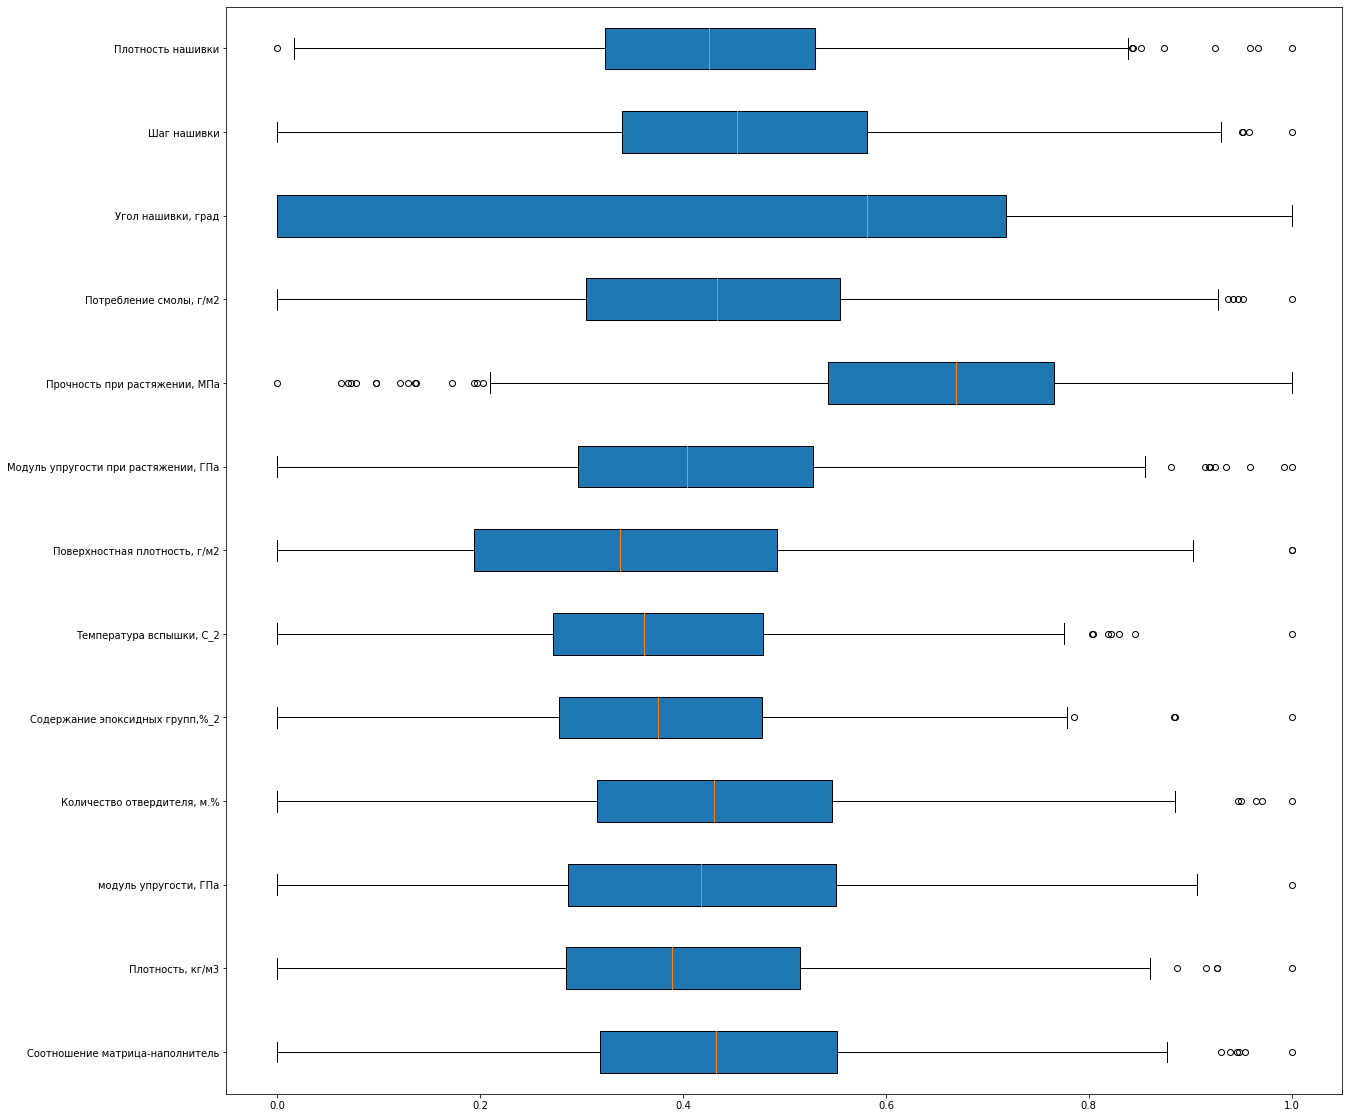

In [53]:
#Построим на "ящики с усами"
scaler = MinMaxScaler()
scaler.fit(df_norm_n)
plt.figure(figsize=(20, 20))
#Выводим "ящики"
plt.boxplot(pd.DataFrame(scaler.transform(df_norm_n)), labels = df_norm_n.columns, patch_artist=True, meanline=True,vert=False)
plt.show()

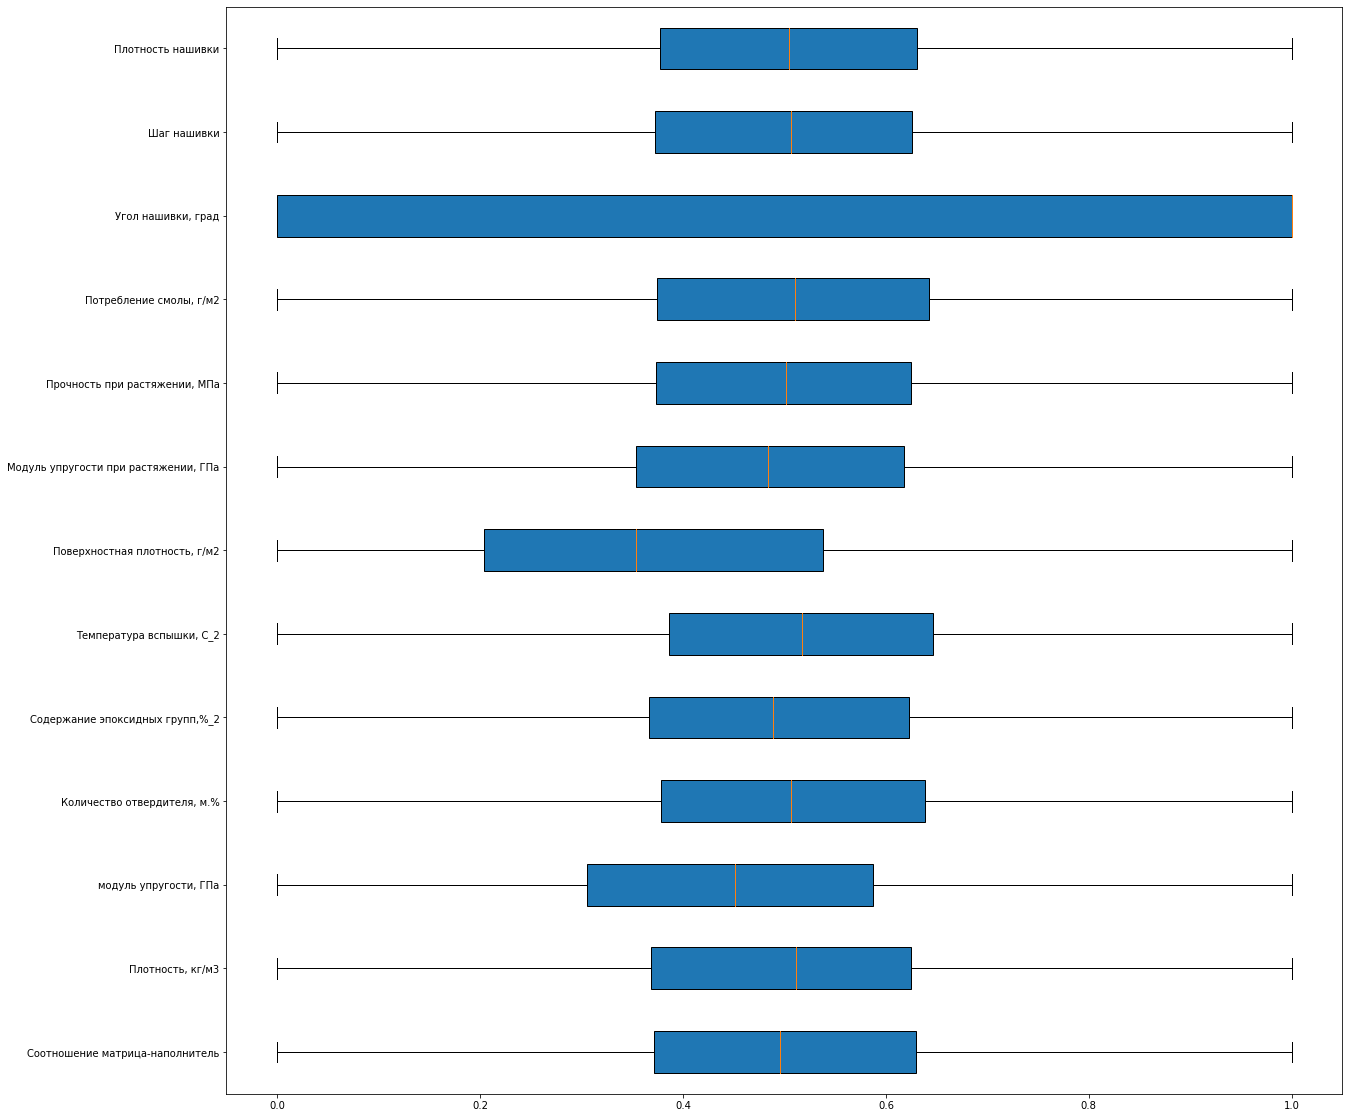

In [54]:
#Построим на "ящики с усами"
scaler = MinMaxScaler()
scaler.fit(df_minmax_n)
plt.figure(figsize=(20, 20))
#Выводим "ящики"
plt.boxplot(pd.DataFrame(scaler.transform(df_minmax_n)), labels = df_minmax_n.columns, patch_artist=True, meanline=True,vert=False)
plt.show()

#### Из графиков видим, что нормализация с помощью "Normalizer" добавляет большое количество выбросов

### Стандартизируем данные

In [79]:
X1 = df_minmax_n.copy()
X2 = df_norm_n.copy()

In [80]:
df_std_X1 = preprocessing.StandardScaler().fit(X1)
df_standart_X1 = df_std_X1.transform(X1)
df_standart_1 = pd.DataFrame(df_standart_X1)

In [81]:
df_standart_1

0         1         2         3         4         5         6   \
0   -1.196467  0.787037  0.007992 -2.286425  0.647585 -0.039740 -0.971971   
1   -1.196467  0.787037  0.007992  0.668092 -0.397291  0.350738 -0.971971   
2   -0.175012  0.787037  0.051553  0.027074  0.028123 -0.039740 -0.971971   
3   -0.178825  0.364514  0.036283  0.027074  0.028123 -0.039740 -0.971971   
4   -0.400390 -0.903054  0.216474  0.027074  0.028123 -0.039740 -0.971971   
..        ...       ...       ...       ...       ...       ...       ...   
917 -0.733662 -0.310284  0.539767 -0.902956 -0.868217  0.979545 -0.974830   
918  0.576611  1.069974 -0.889924  1.303201 -1.087006 -0.811326 -0.470122   
919  0.394018 -0.024589 -0.975122 -0.022536  0.734311 -0.958342  0.919470   
920  0.868603  1.305328  0.016356  1.131763 -1.234469 -0.263996  0.567419   
921  0.983318 -1.178912 -0.973657  0.674952  2.204352  0.374919  0.985849   

           7         8         9         10        11        12  
0   -1.092335  1.187925  0.034181 -1.021932 -1.166792  0.219240  
1   -1.092335  1.187925  0.034181 -1.021932 -0.768833 -0.950227  
2   -1.092335  1.187925  0.034181 -1.021932 -0.768833 -0.050637  
3   -1.092335  1.187925  0.034181 -1.021932 -0.768833  0.219240  
4   -1.092335  1.187925  0.034181 -1.021932 -0.768833  1.118831  
..        ...       ...       ...       ...       ...       ...  
917 -0.070267 -0.163679 -1.629244  0.978538  0.853400 -0.948449  
918 -0.126524 -0.223019 -1.756683  0.978538  1.446055 -0.342933  
919  0.473140  0.444312  0.324984  0.978538 -1.102660  0.905599  
920  0.244441 -0.859827 -0.366368  0.978538 -0.246233  0.062808  
921  0.332727  0.870993 -0.407900  0.978538 -0.339474  1.787628  

[922 rows x 13 columns]

In [82]:
df_std_X2 = preprocessing.StandardScaler().fit(X2)
df_standart_X2 = df_std_X2.transform(X2)
df_standart_2 = pd.DataFrame(df_standart_X2)

In [83]:
df_standart_2

0         1         2         3         4         5         6   \
0   -1.344022 -0.739704 -0.200816 -2.296767 -0.236843 -0.607402 -1.057032   
1   -1.345441 -0.747175 -0.202498  0.206279 -0.967498 -0.318145 -1.057575   
2   -0.451738 -0.750361 -0.161637 -0.338236 -0.674358 -0.613449 -1.057807   
3   -0.442501 -0.847953 -0.166085 -0.321774 -0.644366 -0.588241 -1.054576   
4   -0.613283 -1.187698  0.029262 -0.287783 -0.582440 -0.536193 -1.047905   
..        ...       ...       ...       ...       ...       ...       ...   
832 -0.611740  0.244925  0.698506 -0.717961 -0.431910  1.069823 -0.957813   
833  0.765495  0.947542 -0.845097  1.510843 -0.504742 -0.388569 -0.399034   
834  0.310569 -0.257066 -1.041586 -0.092015  0.387449 -0.913783  0.900208   
835  1.178705  1.348683  0.232161  1.483795 -0.446749  0.257995  0.791727   
836  0.740028 -0.983368 -1.082182  0.405921  1.215635 -0.028221  0.879908   

           7         8         9         10        11        12  
0   -1.368652  1.117964 -0.323459 -1.028401 -1.254727 -0.289138  
1   -1.375318  1.106856 -0.326056 -1.028401 -0.902350 -1.283305  
2   -1.378161  1.102120 -0.327164 -1.028401 -0.902939 -0.522753  
3   -1.338525  1.168161 -0.311720 -1.028401 -0.894733 -0.273004  
4   -1.256686  1.304519 -0.279832 -1.028401 -0.877791  0.543408  
..        ...       ...       ...       ...       ...       ...  
832  0.318630 -0.126064 -1.483165  1.024805  1.012556 -0.752479  
833  0.453525 -0.072727 -1.577696  1.056729  1.683391 -0.090712  
834 -0.051081  0.543038  0.218189  0.907094 -1.078349  0.710914  
835  0.899752 -1.356252 -0.083737  1.113532  0.002210  0.450843  
836 -0.420725  1.066668 -0.568406  0.845192 -0.419273  1.315075  

[837 rows x 13 columns]

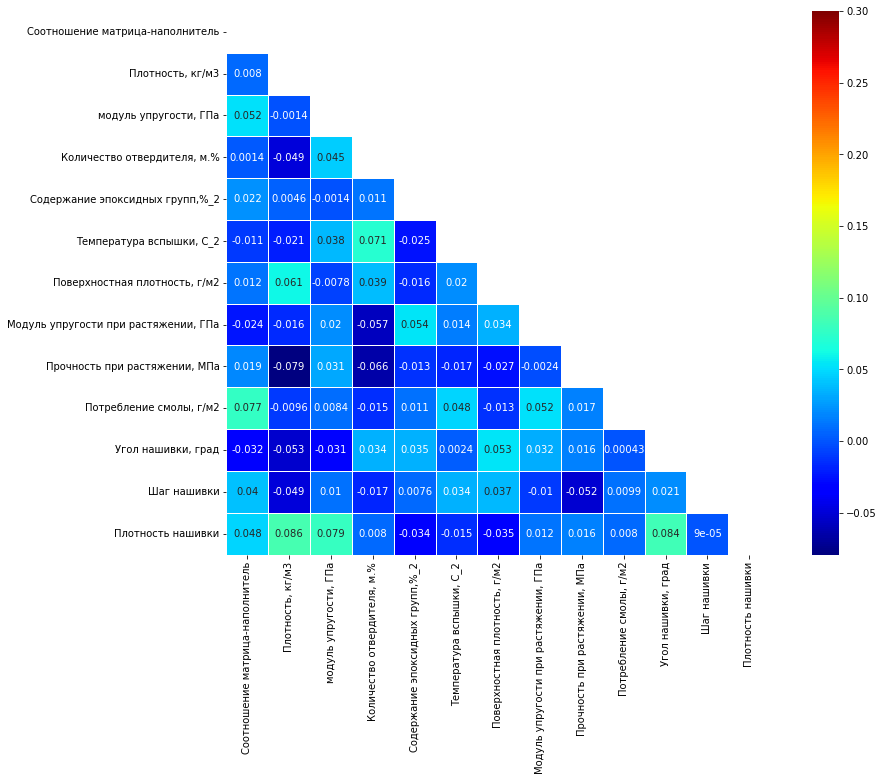

In [84]:
#Визуализаруем данные корреляции
len(X1)
f, ax = plt.subplots(figsize=(15, 10))
corr = np.round_(X1.corr(), decimals=5)
sns.heatmap(corr,annot=True,cmap='jet',square=True,linewidths=1,vmax=.3, mask = np.triu(X1.corr()));

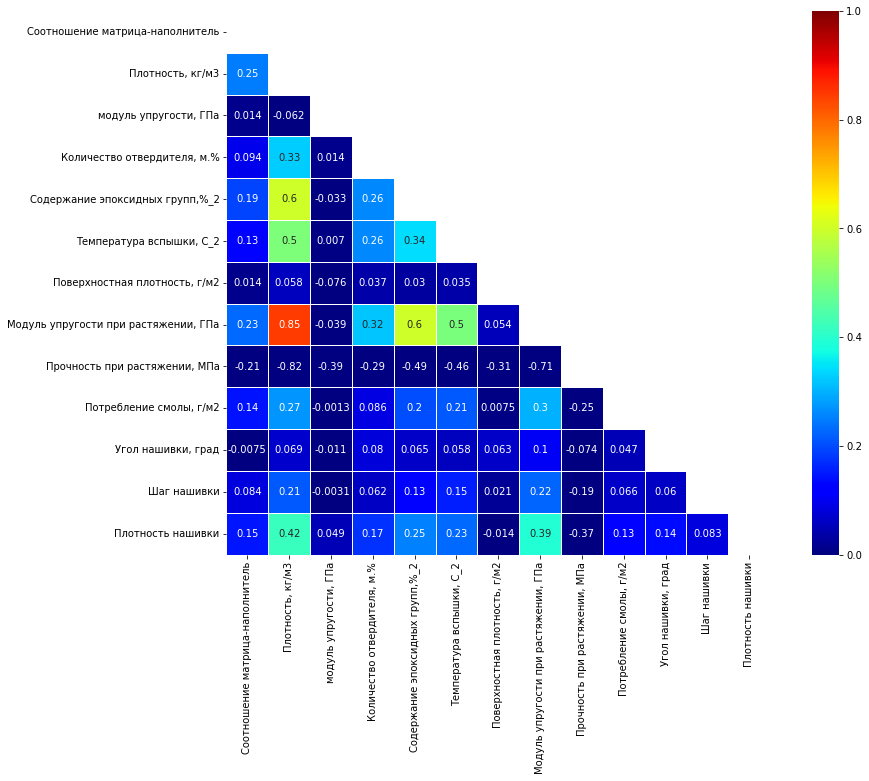

In [96]:
len(X2)
f, ax = plt.subplots(figsize=(15, 10))
corr = np.round_(X2.corr(), decimals=5)
sns.heatmap(corr,annot=True,cmap='jet',square=True,linewidths=1,vmin=0, vmax=1, mask = np.triu(X2.corr()));

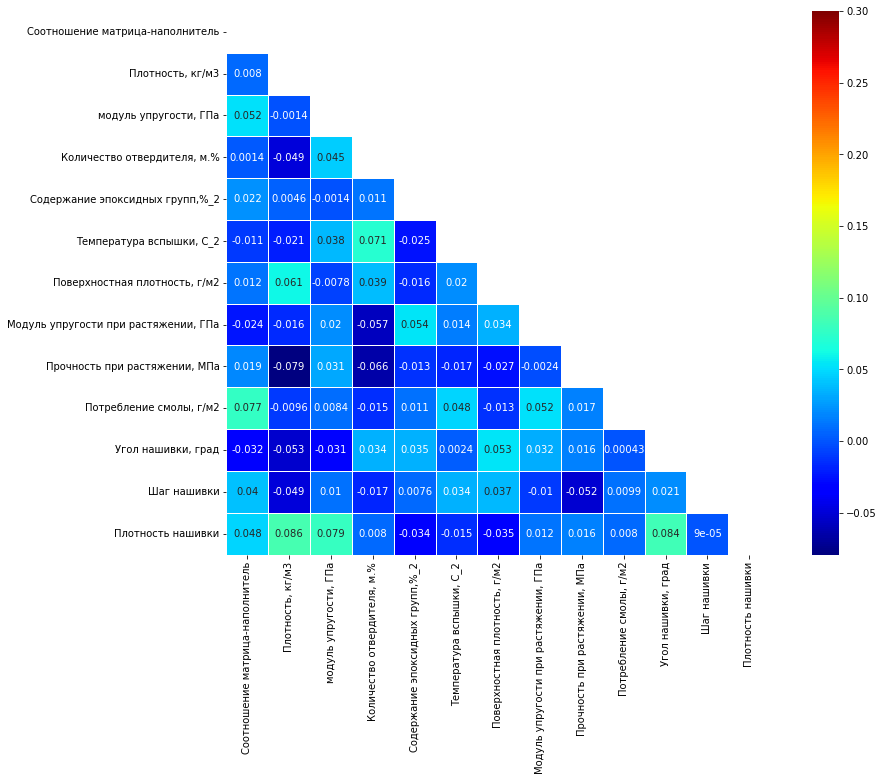

In [88]:
#Визуализаруем данные корреляции
len(df)
f, ax = plt.subplots(figsize=(15, 10))
corr = np.round_(df.corr(), decimals=5)
sns.heatmap(corr,annot=True,cmap='jet',square=True,linewidths=1,vmax=.3, mask = np.triu(df.corr()));

In [97]:
df_norm_n.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                       837.000000        837.000000   
mean                          0.000868          0.587569   
std                           0.000275          0.056993   
min                           0.000163          0.444650   
25%                           0.000679          0.548948   
50%                           0.000857          0.585227   
75%                           0.001052          0.626059   
max                           0.001593          0.743130   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count             837.000000                   837.000000   
mean                0.216978                     0.032887   
std                 0.092124                     0.008474   
min                 0.000709                     0.011339   
25%                 0.151021                     0.027292   
50%                 0.219229                     0.032910   
75%                 0.280808                     0.038817   
max                 0.476145                     0.055088   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                       837.000000                837.000000   
mean                          0.006601                  0.085021   
std                           0.000926                  0.014082   
min                           0.004113                  0.049402   
25%                           0.005925                  0.075135   
50%                           0.006589                  0.083934   
75%                           0.007208                  0.094452   
max                           0.009122                  0.123083   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                     837.000000                            837.000000   
mean                        0.142062                              0.021821   
std                         0.081065                              0.002203   
min                         0.001902                              0.016105   
25%                         0.078825                              0.020292   
50%                         0.138593                              0.021720   
75%                         0.199600                              0.023319   
max                         0.368343                              0.027834   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                     837.000000               837.000000   
mean                        0.742763                 0.064855   
std                         0.056655                 0.017766   
min                         0.590461                 0.021630   
25%                         0.706068                 0.052063   
50%                         0.747345                 0.064468   
75%                         0.782554                 0.076808   
max                         0.877580                 0.114133   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count          837.000000   837.000000         837.000000  
mean             0.013891     0.002028           0.017140  
std              0.013515     0.000760           0.003525  
min              0.000000     0.000011           0.008164  
25%              0.000000     0.001505           0.014780  
50%              0.022461     0.002013           0.017152  
75%              0.026792     0.002523           0.019443  
max              0.034285     0.003983           0.026496

In [98]:
df_minmax_n.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                       922.000000        922.000000   
mean                          0.499412          0.502904   
std                           0.187858          0.188395   
min                           0.000000          0.000000   
25%                           0.371909          0.368184   
50%                           0.495189          0.511396   
75%                           0.629774          0.624719   
max                           1.000000          1.000000   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count             922.000000                   922.000000   
mean                0.451341                     0.506200   
std                 0.201534                     0.186876   
min                 0.000000                     0.000000   
25%                 0.305188                     0.378514   
50%                 0.451377                     0.506382   
75%                 0.587193                     0.638735   
max                 1.000000                     1.000000   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                       922.000000                922.000000   
mean                          0.490578                  0.516739   
std                           0.180548                  0.190721   
min                           0.000000                  0.000000   
25%                           0.366571                  0.386228   
50%                           0.488852                  0.516931   
75%                           0.623046                  0.646553   
max                           1.000000                  1.000000   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                     922.000000                            922.000000   
mean                        0.373295                              0.487343   
std                         0.217269                              0.196366   
min                         0.000000                              0.000000   
25%                         0.204335                              0.353512   
50%                         0.354161                              0.483718   
75%                         0.538397                              0.617568   
max                         1.000000                              1.000000   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                     922.000000               922.000000   
mean                        0.503776                 0.507876   
std                         0.188668                 0.199418   
min                         0.000000                 0.000000   
25%                         0.373447                 0.374647   
50%                         0.501481                 0.510143   
75%                         0.624299                 0.642511   
max                         1.000000                 1.000000   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count          922.000000   922.000000         922.000000  
mean             0.510846     0.503426           0.503938  
std              0.500154     0.183587           0.193933  
min              0.000000     0.000000           0.000000  
25%              0.000000     0.372844           0.376869  
50%              1.000000     0.506414           0.504310  
75%              1.000000     0.626112           0.630842  
max              1.000000     1.000000           1.000000

### Разработка и обучение моделей 

In [99]:
#Входные переменные
col_in = ["Плотность, кг/м3", "модуль упругости, ГПа", "Количество отвердителя, м.%",
          "Содержание эпоксидных групп,%_2", "Температура вспышки, С_2",
          "Поверхностная плотность, г/м2", "Потребление смолы, г/м2",
          "Угол нашивки, град","Шаг нашивки","Плотность нашивки"]
#Входные данные
df_trn1 = df_minmax_n[col_in]
df_trn2 = df_norm_n[col_in]

#выходные переменные
col_out = ["Соотношение матрица-наполнитель",
           "Модуль упругости при растяжении, ГПа",
           "Прочность при растяжении, МПа"]

#Выходные данные
df_trg1 = df_minmax_n[col_out]
df_trg2 = df_norm_n[col_out]

In [100]:
#тестовая и обучающая выборки 70/30
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(df_trn1, df_trg1, test_size=0.3)
Xtrain2, Xtest2, Ytrain2, Ytest2 = train_test_split(df_trn2, df_trg2, test_size=0.3)

In [101]:
model_list1 = [LinearRegression(),   # метод наименьших квадратов
               KNeighborsRegressor(n_neighbors=5), # метод ближайших соседей
               SVR(kernel='linear')]               # метод опорных векторов с линейным ядром

model_list1

[LinearRegression(), KNeighborsRegressor(), SVR(kernel='linear')]

In [103]:
#Проверка различных моделей при стандартных параметрах
#создаем временные структуры
TestModels1 = pd.DataFrame()
tmp1 = {}
#для каждой модели из списка
for model1 in model_list1:
    #получаем имя модели
    m1 = str(model1)
    tmp1['Model1'] = m1[:m1.index('(')]    
    #для каждого столбца результирующего набора
    for i in range(Ytrain1.shape[1]):
        #обучаем модель
        model1.fit(Xtrain1, Ytrain1[col_out[i]]) 
        #вычисляем коэффициент детерминации
        tmp1['R2_Y%s'%str(i+1)] = r2_score(Ytest1[col_out[i]], model1.predict(Xtest1))
    #записываем данные и итоговый DataFrame
    TestModels1 = TestModels1.append([tmp1])
#делаем индекс по названию модели
TestModels1.set_index('Model1', inplace=True)

In [106]:
TestModels1

R2_Y1     R2_Y2     R2_Y3
Model1                                           
LinearRegression    -0.030933 -0.003654 -0.025295
KNeighborsRegressor -0.232930 -0.045402 -0.239561
SVR                 -0.019778 -0.013608 -0.025253

In [107]:
model_list2 = [LinearRegression(),   # метод наименьших квадратов
               KNeighborsRegressor(n_neighbors=5), # метод ближайших соседей
               SVR(kernel='linear')]               # метод опорных векторов с линейным ядром

model_list2

[LinearRegression(), KNeighborsRegressor(), SVR(kernel='linear')]

In [226]:
#Проверка различных моделей при стандартных параметрах
#создаем временные структуры
TestModels2 = pd.DataFrame()
tmp2 = {}
#для каждой модели из списка
for model2 in model_list2:
    #получаем имя модели
    m2 = str(model2)
    tmp2['Model2'] = m2[:m2.index('(')]    
    #для каждого столбца результирующего набора
    for i in range(Ytrain2.shape[1]):
        #обучаем модель
        model2.fit(Xtrain2, Ytrain2[col_out[i]]) 
        #вычисляем коэффициент детерминации
        tmp2['R2_Y%s'%str(i+1)] = r2_score(Ytest2[col_out[i]], model2.predict(Xtest2))
    #записываем данные и итоговый DataFrame
    TestModels2 = TestModels1.append([tmp2])
#делаем индекс по названию модели
TestModels2.set_index('Model2', inplace=True)

In [109]:
TestModels2

R2_Y1     R2_Y2     R2_Y3
Model2                              
NaN    -0.030933 -0.003654 -0.025295
NaN    -0.232930 -0.045402 -0.239561
NaN    -0.019778 -0.013608 -0.025253
SVR    -0.000373 -0.002548  0.439090

In [110]:
#Импортируем функции для поиска по сетке параметров с перекрестной проверкой
from sklearn.model_selection import GridSearchCV

In [112]:
#Отделяем выходные переменные и входные
#Сперва проверим модели для прогнозирования прочности на растяжение
col_names_out_1 = ["Прочность при растяжении, МПа"]
col_names_in_1 = ["Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2","Угол нашивки, град","Шаг нашивки","Плотность нашивки"]
#Выходные
trg_1 = df_minmax_n[col_names_out_1]
trg_2 = df_norm_n[col_names_out_1]
#Входные
trn_1 = df_minmax_n[col_names_in_1]
trn_2 = df_norm_n[col_names_in_1]

In [113]:
#Подготовка обучающей и тестовой выборок (соотношение 70 на 30)
#Перекрестную проверку будем проводить на 70% данных 30% оставим на итоговое тестирование

Xtrain1_1, Xtest1_1, Ytrain1_1, Ytest1_1 = train_test_split(trn_1, trg_1, test_size=0.3)
Xtrain1_2, Xtest1_2, Ytrain1_2, Ytest1_2 = train_test_split(trn_1, trg_1, test_size=0.3)

Xtrain2_1, Xtest2_1, Ytrain2_1, Ytest2_1 = train_test_split(trn_2, trg_2, test_size=0.3)
Xtrain2_2, Xtest2_2, Ytrain2_2, Ytest2_2 = train_test_split(trn_2, trg_2, test_size=0.3)

In [116]:
#Зададим сетку параметров, по которым будем оптимизировать модель
t_search_1 = {'weights': ['uniform', 'distance'],
               'n_neighbors': list(np.linspace(5, 100, 10, dtype = int)),
               'algorithm': ['auto', 'ball_tree','kd_tree', 'brute'],
               'leaf_size': list(np.linspace(10, 100, 10, dtype = int))}
#В качестве первой модели будем использовать метод ближайших соседей
clf_1 = KNeighborsRegressor()



In [117]:
#Зададим сетку параметров, по которым будем оптимизировать модель
t_search_2 = {'weights': ['uniform', 'distance'],
               'n_neighbors': list(np.linspace(5, 100, 10, dtype = int)),
               'algorithm': ['auto', 'ball_tree','kd_tree', 'brute'],
               'leaf_size': list(np.linspace(10, 100, 10, dtype = int))}
#В качестве первой модели будем использовать метод ближайших соседей
clf_2 = KNeighborsRegressor()


In [118]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model_1 = GridSearchCV(estimator = clf_1, scoring = 'r2', param_grid = t_search_1, cv = 10, verbose= 1, n_jobs = -1)
model_1.fit(Xtrain1_1,Ytrain1_1)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_neighbors': [5, 15, 26, 36, 47, 57, 68, 78, 89,
                                         100],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=1)

In [119]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model_2 = GridSearchCV(estimator = clf_2, scoring = 'r2', param_grid = t_search_2, cv = 10, verbose= 1, n_jobs = -1)
model_2.fit(Xtrain2_1,Ytrain2_1)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_neighbors': [5, 15, 26, 36, 47, 57, 68, 78, 89,
                                         100],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=1)

In [120]:
best_estimator = model_1.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model_1.best_score_)

KNeighborsRegressor(leaf_size=10, n_neighbors=47)
-0.046649424427230156


In [121]:
best_estimator = model_2.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model_2.best_score_)

KNeighborsRegressor(leaf_size=10, weights='distance')
0.9563464518631758


In [122]:
#Определяем функцию для вычисления точности модели. На входе модель, а также входные параметры и целевая переменная
def evaluate(model, test_features, test_labels):
    #Делаем предсказание на основе входных параметров
    predictions = model.predict(test_features)
    #Считаем абсолютные ошибки в предсказаниях (разность между предсказанным значением и целевым значением)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    #Определяем точность модели
    accuracy = 100 - mape
    print('Средняя абсолютная ошибка: {:0.4f}'.format(np.mean(errors.values)))
    #print('Точность = {:0.2f}%.'.format(accuracy[0]))
    return accuracy

In [123]:
#Подставляем оптимальные гиперпараметры в модель
model_base_1 = KNeighborsRegressor(algorithm='brute', leaf_size=10, n_neighbors=100, weights='distance')
#Обучаем модель
model_base_1.fit(Xtrain1_1,Ytrain1_1)
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate(model_base_1, Xtrain1_1,Ytrain1_1)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate(model_base_1, Xtest1_1,Ytest1_1)

Средняя абсолютная ошибка: 0.0000
Средняя абсолютная ошибка: 0.1546


In [124]:
#Подставляем оптимальные гиперпараметры в модель
model_base_2 = KNeighborsRegressor(algorithm='brute', leaf_size=10, n_neighbors=100, weights='distance')
#Обучаем модель
model_base_2.fit(Xtrain2_1,Ytrain2_1)
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate(model_base_2, Xtrain2_1,Ytrain2_1)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate(model_base_2, Xtest2_1,Ytest2_1)

Средняя абсолютная ошибка: 0.0000
Средняя абсолютная ошибка: 0.0202


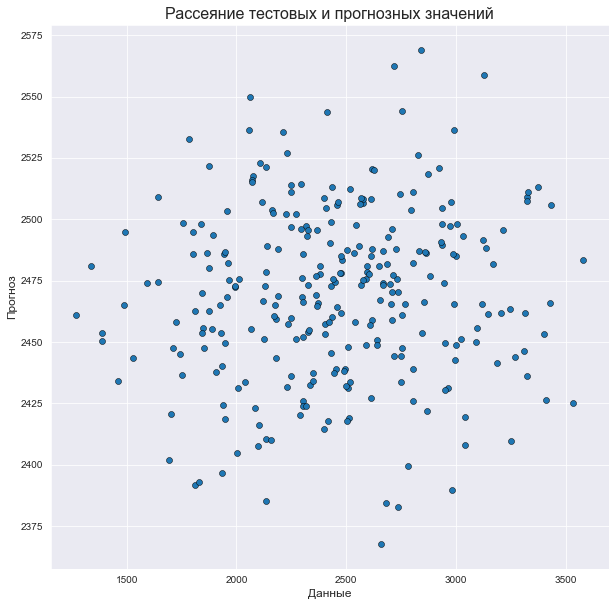

Данные      Прогноз
0    1993.459958  2472.217918
1    2304.313891  2426.077808
2    2429.619356  2472.748191
3    3188.136358  2441.659824
4    3167.779711  2481.768610
..           ...          ...
272  2498.894803  2431.937646
273  1841.004409  2453.697584
274  2156.666591  2410.028727
275  2509.612948  2447.855288
276  1337.424692  2481.003305

[277 rows x 2 columns]

In [142]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict_1 = model_base_1.predict(Xtest1_1)
predict_1_values = np.ravel(predict_1)
#Тестовые данные
Ytst_1 = Ytest1_1.copy()
test_1_values = np.ravel(Ytst_1)
#Преобразуем нормализованные данные к исходным
col_1 = ["Прочность при растяжении, МПа"]
#Определим параметры, которые использовались для нормализации
min_1 = np.min(df[col_1])
max_1 = np.max(df[col_1])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict_1_values):
    predict_1_values[i] = predict_1_values[i]*(max_1 - min_1) + min_1
    test_1_values[i] = test_1_values[i]*(max_1 - min_1) + min_1
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results_1 = pd.DataFrame({'Данные': test_1_values,'Прогноз': predict_1_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=16)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results_1, edgecolor='black', palette='cubehelix', marker="o")
plt.show()
feature_results_1

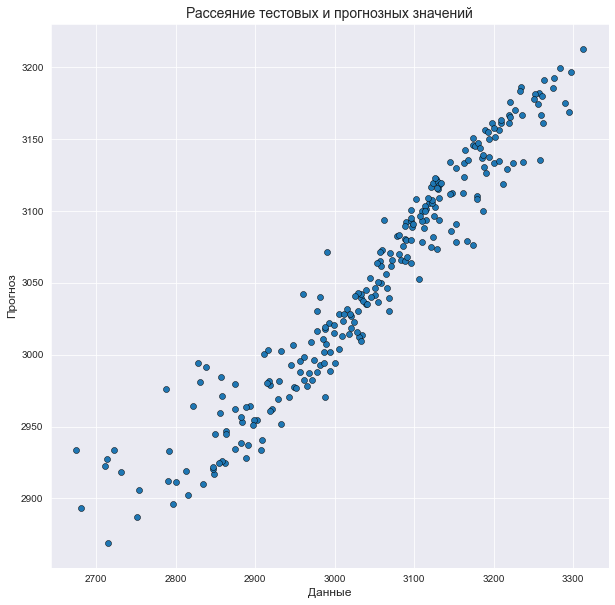

Данные      Прогноз
0    2731.187634  2918.466881
1    3005.029020  3003.927511
2    3095.598833  3100.544471
3    2910.996260  3000.398009
4    3118.143272  3105.850278
..           ...          ...
247  2985.209632  3010.800784
248  3039.836511  3045.180054
249  2874.154431  2962.153945
250  3067.883163  3030.528017
251  2987.594837  3019.108070

[252 rows x 2 columns]

In [140]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict_2 = model_base_2.predict(Xtest2_1)
predict_2_values = np.ravel(predict_2)
#Тестовые данные
Ytst_2 = Ytest2_1.copy()
test_2_values = np.ravel(Ytst_2)
#Преобразуем нормализованные данные к исходным
col_2 = ["Прочность при растяжении, МПа"]
#Определим параметры, которые использовались для нормализации
min_2 = np.min(df[col_2])
max_2 = np.max(df[col_2])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict_2_values):
    predict_2_values[i] = predict_2_values[i]*(max_2 - min_2) + min_2
    test_2_values[i] = test_2_values[i]*(max_2 - min_2) + min_2
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results_2 = pd.DataFrame({'Данные': test_2_values,'Прогноз': predict_2_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results_2, edgecolor='black', palette='cubehelix', marker="o")

plt.show()
feature_results_2

### Метод градиентного бустинга

In [145]:
#Зададим сетку параметров, по которым будем оптимизировать модель (вторая модель)
t_search_11 = {'n_estimators': list(np.linspace(100, 500, 5, dtype = int)),
             'loss': ['ls', 'lad', 'huber'],
             'max_depth': [2, 3, 5, 10, 15]}
#В качестве второй модели будем использовать метод градиентного бустинга
clf_11 = GradientBoostingRegressor()

In [146]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model_11 = GridSearchCV(estimator = clf_11, scoring = 'r2', param_grid = t_search_11, cv = 10, verbose= 1, n_jobs = -1)
model_11.fit(Xtrain1_2,np.ravel(Ytrain1_2))
#Используем преобразование np.ravel() массива [[],[],...] к одномерному массиву [,,...]

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'loss': ['ls', 'lad', 'huber'],
                         'max_depth': [2, 3, 5, 10, 15],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='r2', verbose=1)

In [147]:
best_estimator = model_11.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model_11.best_score_)

GradientBoostingRegressor(loss='lad', max_depth=2)
-0.05833184778133009


In [148]:
#Зададим сетку параметров, по которым будем оптимизировать модель (вторая модель)
t_search_22 = {'n_estimators': list(np.linspace(100, 500, 5, dtype = int)),
             'loss': ['ls', 'lad', 'huber'],
             'max_depth': [2, 3, 5, 10, 15]}
#В качестве второй модели будем использовать метод градиентного бустинга
clf_22 = GradientBoostingRegressor()

In [149]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model_22 = GridSearchCV(estimator = clf_22, scoring = 'r2', param_grid = t_search_22, cv = 10, verbose= 1, n_jobs = -1)
model_22.fit(Xtrain2_2,np.ravel(Ytrain2_2))
#Используем преобразование np.ravel() массива [[],[],...] к одномерному массиву [,,...]

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'loss': ['ls', 'lad', 'huber'],
                         'max_depth': [2, 3, 5, 10, 15],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='r2', verbose=1)

In [150]:
best_estimator = model_22.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model_22.best_score_)

GradientBoostingRegressor(max_depth=2, n_estimators=500)
0.9896989075717396


In [151]:
#Определяем функцию для вычисления точности модели. На входе модель, а также входные параметры и целевая переменная
def evaluate_2(model, test_features, test_labels):
    #Делаем предсказание на основе входных параметров
    predictions = model.predict(test_features)
    #Преобразуем к виду [[],[],...] из одномерного массива
    predict = np.reshape(predictions,(predictions.size, 1))
    #Считаем абсолютные ошибки в предсказаниях (разность между предсказанным значением и целевым значением)
    errors = abs(predict - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    #Определяем точность модели
    accuracy = 100 - mape
    print('Средняя абсолютная ошибка: {:0.4f}'.format(np.mean(errors.values)))
    #print('Точность = {:0.2f}%.'.format(accuracy[0]))
    return accuracy

In [152]:
#Подставляем оптимальные гиперпараметры в модель
model_base_11 = GradientBoostingRegressor(loss='lad', max_depth=2)
#Обучаем модель
model_base_11.fit(Xtrain1_2,np.ravel(Ytrain1_2))

GradientBoostingRegressor(loss='lad', max_depth=2)

In [153]:
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate_2(model_base_11, Xtrain1_2, Ytrain1_2)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate_2(model_base_11, Xtest1_2, Ytest1_2)

Средняя абсолютная ошибка: 0.1288
Средняя абсолютная ошибка: 0.1655


In [154]:
#Подставляем оптимальные гиперпараметры в модель
model_base_22 = GradientBoostingRegressor(loss='lad', max_depth=2)
#Обучаем модель
model_base_22.fit(Xtrain2_2,np.ravel(Ytrain2_2))

GradientBoostingRegressor(loss='lad', max_depth=2)

In [155]:
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate_2(model_base_22, Xtrain2_2, Ytrain2_2)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate_2(model_base_22, Xtest2_2, Ytest2_2)

Средняя абсолютная ошибка: 0.0050
Средняя абсолютная ошибка: 0.0085


In [156]:
#Важность папаметров в модели
importances_11 = model_base_11.feature_importances_
#получаем названия колонок параметров
feature_list_11 = list(Xtrain1_2.columns)
#Формируем таблицу для представления
feature_results_11 = pd.DataFrame({'Параметр': feature_list_11,'Важность параметра': importances_11})
#Сортируем по уменьшению важности
feature_results_11 = feature_results_11.sort_values('Важность параметра',ascending = False).reset_index(drop=True)

In [157]:
feature_results_11

Параметр  Важность параметра
0    Поверхностная плотность, г/м2            0.237175
1                 Плотность, кг/м3            0.197958
2      Количество отвердителя, м.%            0.139710
3            модуль упругости, ГПа            0.114360
4         Температура вспышки, С_2            0.102849
5          Потребление смолы, г/м2            0.066593
6  Содержание эпоксидных групп,%_2            0.056362
7                Плотность нашивки            0.050393
8                      Шаг нашивки            0.034600
9               Угол нашивки, град            0.000000

In [158]:
#Важность папаметров в модели
importances_22 = model_base_22.feature_importances_
#получаем названия колонок параметров
feature_list_22 = list(Xtrain2_2.columns)
#Формируем таблицу для представления
feature_results_22 = pd.DataFrame({'Параметр': feature_list_22,'Важность параметра': importances_22})
#Сортируем по уменьшению важности
feature_results_22 = feature_results_22.sort_values('Важность параметра',ascending = False).reset_index(drop=True)

In [159]:
feature_results_22

Параметр  Важность параметра
0                 Плотность, кг/м3            0.438427
1            модуль упругости, ГПа            0.278864
2    Поверхностная плотность, г/м2            0.196900
3         Температура вспышки, С_2            0.028335
4          Потребление смолы, г/м2            0.019608
5  Содержание эпоксидных групп,%_2            0.019214
6                Плотность нашивки            0.007240
7               Угол нашивки, град            0.006026
8      Количество отвердителя, м.%            0.003950
9                      Шаг нашивки            0.001436

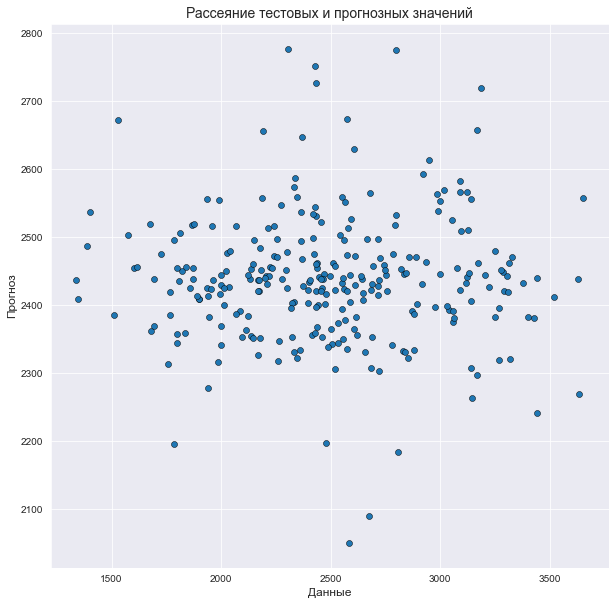

Данные      Прогноз
0    2610.449767  2473.034736
1    2715.834461  2498.081368
2    1680.971057  2362.814401
3    1673.355146  2519.270206
4    1960.882953  2437.678365
..           ...          ...
272  2256.858423  2471.742267
273  2262.415717  2347.568053
274  2438.219683  2368.266324
275  1991.478742  2555.127038
276  1955.437887  2423.697480

[277 rows x 2 columns]

In [161]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict_11 = model_base_11.predict(Xtest1_2)
predict_11_values = np.ravel(predict_11)
#Тестовые данные
Ytst_11 = Ytest1_2.copy()
test_11_values = np.ravel(Ytst_11)
#Преобразуем нормализованные данные к исходным
col_11 = ["Прочность при растяжении, МПа"]
#Определим параметры, которые использовались для нормализации
min_11 = np.min(df[col_11])
max_11 = np.max(df[col_11])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict_11_values):
    predict_11_values[i] = predict_11_values[i]*(max_11 - min_11) + min_11
    test_11_values[i] = test_11_values[i]*(max_11 - min_11) + min_11
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results_11 = pd.DataFrame({'Данные': test_11_values,'Прогноз': predict_11_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results_11, edgecolor='black', palette='cubehelix')
plt.show()
feature_results_11

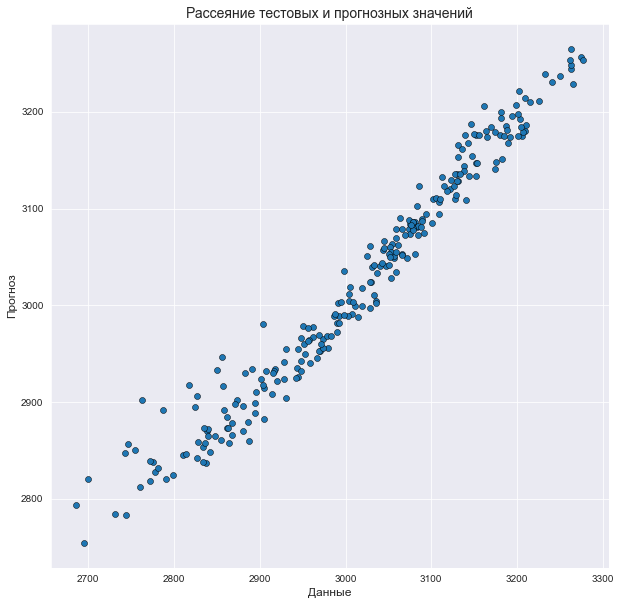

Данные      Прогноз
0    3075.513003  3084.535920
1    3019.465343  2999.180338
2    3058.533799  3034.767054
3    3129.901407  3136.223928
4    3083.324200  3102.851986
..           ...          ...
247  2685.747892  2793.348055
248  3028.420736  3024.451303
249  3152.256939  3133.135592
250  3032.628666  3041.220577
251  3051.973752  3049.619002

[252 rows x 2 columns]

In [162]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict_22 = model_base_22.predict(Xtest2_2)
predict_22_values = np.ravel(predict_22)
#Тестовые данные
Ytst_22 = Ytest2_2.copy()
test_22_values = np.ravel(Ytst_22)
#Преобразуем нормализованные данные к исходным
col_22 = ["Прочность при растяжении, МПа"]
#Определим параметры, которые использовались для нормализации
min_22 = np.min(df[col_22])
max_22 = np.max(df[col_22])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict_22_values):
    predict_22_values[i] = predict_22_values[i]*(max_22 - min_22) + min_22
    test_22_values[i] = test_22_values[i]*(max_22 - min_22) + min_22
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results_22 = pd.DataFrame({'Данные': test_22_values,'Прогноз': predict_22_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results_22, edgecolor='black', palette='cubehelix')
plt.show()
feature_results_22

In [163]:
#Отделяем выходные переменные и входные
#Теперь проверим модели для прогнозирования Модуль упругости при растяжении, ГПа
col_names_out_2 = ["Модуль упругости при растяжении, ГПа"]
col_names_in_2 =  ["Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2",
                   "Температура вспышки, С_2","Поверхностная плотность, г/м2","Потребление смолы, г/м2","Угол нашивки, град","Шаг нашивки","Плотность нашивки"]

#Выходные
trg_11 = df_minmax_n[col_names_out_2]
trg_22 = df_norm_n[col_names_out_2]
#Входные
trn_11 = df_minmax_n[col_names_in_2]
trn_22 = df_norm_n[col_names_in_2]


In [164]:
#тестовая и обучающая выборки 70/30
Xtrain11, Xtest11, Ytrain11, Ytest11 = train_test_split(trn_11, trg_11, test_size=0.3)
Xtrain111, Xtest111, Ytrain111, Ytest111 = train_test_split(trn_11, trg_11, test_size=0.3)

Xtrain22, Xtest22, Ytrain22, Ytest22 = train_test_split(trn_22, trg_22, test_size=0.3)
Xtrain222, Xtest222, Ytrain222, Ytest222 = train_test_split(trn_22, trg_22, test_size=0.3)

In [165]:
#Зададим сетку параметров, по которым будем оптимизировать модель
#t_search21 = {'fit_intercept': [True, False],
#               'positive': [True, False]}
t_search11 = {'fit_intercept': [True, False]}
#               'positive': [True, False]}
#В качестве первой модели будем использовать линейную регрессию
clf11 = LinearRegression()
t_search11

{'fit_intercept': [True, False]}

In [166]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model11 = GridSearchCV(estimator = clf11, scoring = 'r2', param_grid = t_search11, cv = 10, verbose= 1, n_jobs = -1)
model11.fit(Xtrain11,Ytrain11)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, scoring='r2',
             verbose=1)

In [168]:
best_estimator = model11.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model11.best_score_)

LinearRegression()
-0.026111116626460085


In [169]:
#Подставляем оптимальные гиперпараметры в модель
model_base11 = LinearRegression()
#Обучаем модель
model_base11.fit(Xtrain11,Ytrain11)

LinearRegression()

In [171]:
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate(model_base11, Xtrain11,Ytrain11)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate(model_base11, Xtest11, Ytest11)

Средняя абсолютная ошибка: 0.1608
Средняя абсолютная ошибка: 0.1509


In [172]:
#Важность папаметров в модели
importances11 = np.ravel(model_base11.coef_)
#получаем названия колонок параметров
feature_list11 = list(Xtrain11.columns)
#Формируем таблицу для представления
feature_results11 = pd.DataFrame({'Параметр': feature_list11,'Важность параметра': importances11})
#Сортируем по уменьшению важности
feature_results11 = feature_results11.sort_values('Важность параметра',ascending = False).reset_index(drop=True)

In [174]:
feature_results11

Параметр  Важность параметра
0  Содержание эпоксидных групп,%_2            0.063776
1          Потребление смолы, г/м2            0.047994
2    Поверхностная плотность, г/м2            0.029864
3                      Шаг нашивки            0.012579
4                Плотность нашивки            0.003684
5            модуль упругости, ГПа           -0.000659
6               Угол нашивки, град           -0.003470
7         Температура вспышки, С_2           -0.019054
8                 Плотность, кг/м3           -0.028149
9      Количество отвердителя, м.%           -0.055559

In [175]:
#Зададим сетку параметров, по которым будем оптимизировать модель
#t_search21 = {'fit_intercept': [True, False],
#               'positive': [True, False]}
t_search22 = {'fit_intercept': [True, False]}
#               'positive': [True, False]}
#В качестве первой модели будем использовать линейную регрессию
clf22 = LinearRegression()
t_search22

{'fit_intercept': [True, False]}

In [176]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model22 = GridSearchCV(estimator = clf22, scoring = 'r2', param_grid = t_search11, cv = 10, verbose= 1, n_jobs = -1)
model22.fit(Xtrain22,Ytrain22)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, scoring='r2',
             verbose=1)

In [177]:
best_estimator = model22.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model22.best_score_)

LinearRegression()
0.7267829904556276


In [178]:
#Подставляем оптимальные гиперпараметры в модель
model_base22 = LinearRegression()
#Обучаем модель
model_base22.fit(Xtrain22,Ytrain22)

LinearRegression()

In [180]:
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate(model_base22, Xtrain22,Ytrain22)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate(model_base22, Xtest22, Ytest22)

Средняя абсолютная ошибка: 0.0009
Средняя абсолютная ошибка: 0.0009


In [181]:
#Важность папаметров в модели
importances22 = np.ravel(model_base22.coef_)
#получаем названия колонок параметров
feature_list22 = list(Xtrain22.columns)
#Формируем таблицу для представления
feature_results22 = pd.DataFrame({'Параметр': feature_list22,'Важность параметра': importances22})
#Сортируем по уменьшению важности
feature_results22 = feature_results22.sort_values('Важность параметра',ascending = False).reset_index(drop=True)

In [182]:
feature_results22

Параметр  Важность параметра
0  Содержание эпоксидных групп,%_2            0.348776
1                      Шаг нашивки            0.090455
2                 Плотность, кг/м3            0.025882
3                Плотность нашивки            0.019128
4         Температура вспышки, С_2            0.013774
5      Количество отвердителя, м.%            0.008711
6          Потребление смолы, г/м2            0.007674
7               Угол нашивки, град            0.003853
8            модуль упругости, ГПа            0.000047
9    Поверхностная плотность, г/м2           -0.000353

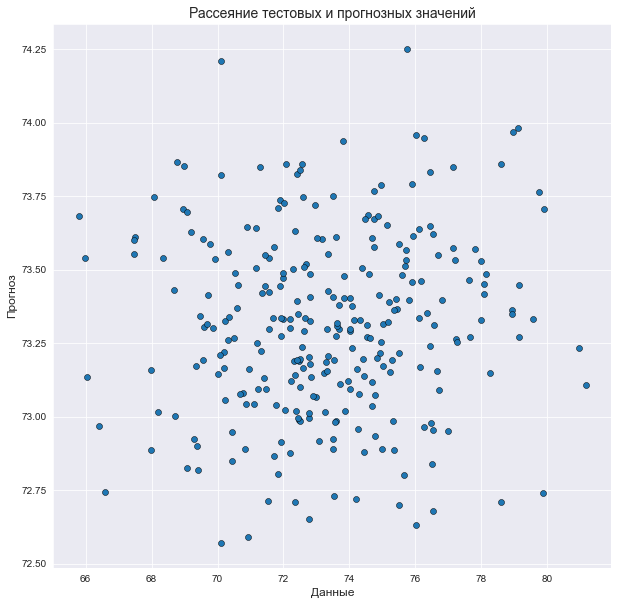

Данные    Прогноз
0    75.187942  73.390211
1    74.672377  73.608982
2    76.007115  72.632404
3    74.554006  73.686407
4    72.325588  73.189232
..         ...        ...
272  74.079019  73.232463
273  73.543128  73.192495
274  71.175111  73.641605
275  70.060483  73.210493
276  71.673907  73.337079

[277 rows x 2 columns]

In [183]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict11 = model_base11.predict(Xtest11)
predict11_values = np.ravel(predict11)
#Тестовые данные
tv11 = Ytest11.copy()
test11_values = np.ravel(tv11)
#Преобразуем нормализованные данные к исходным
col11 = ["Модуль упругости при растяжении, ГПа"]
#Определим параметры, которые использовались для нормализации
min11 = np.min(df[col11])
max11 = np.max(df[col11])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict11_values):
    predict11_values[i] = predict11_values[i]*(max11 - min11) + min11
    test11_values[i] = test11_values[i]*(max11 - min11) + min11
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results11 = pd.DataFrame({'Данные': test11_values,'Прогноз': predict11_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results11, edgecolor='black', palette='cubehelix')
plt.show()
feature_results11

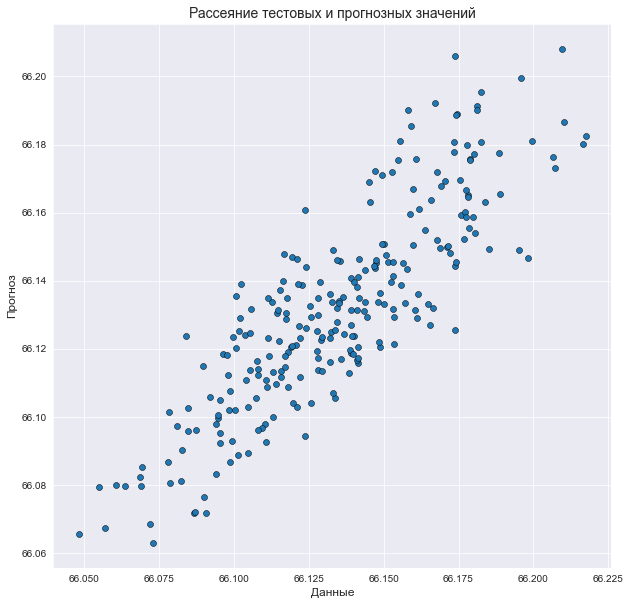

Данные    Прогноз
0    66.104819  66.103029
1    66.160714  66.175785
2    66.159139  66.185353
3    66.127873  66.125390
4    66.177853  66.179916
..         ...        ...
247  66.210186  66.186612
248  66.111366  66.123212
249  66.129569  66.123408
250  66.135667  66.117103
251  66.139894  66.118540

[252 rows x 2 columns]

In [184]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict22 = model_base22.predict(Xtest22)
predict22_values = np.ravel(predict22)
#Тестовые данные
tv22 = Ytest22.copy()
test22_values = np.ravel(tv22)
#Преобразуем нормализованные данные к исходным
col22 = ["Модуль упругости при растяжении, ГПа"]
#Определим параметры, которые использовались для нормализации
min22 = np.min(df[col22])
max22 = np.max(df[col22])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict22_values):
    predict22_values[i] = predict22_values[i]*(max22 - min22) + min22
    test22_values[i] = test22_values[i]*(max22 - min22) + min22
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results22 = pd.DataFrame({'Данные': test22_values,'Прогноз': predict22_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results22, edgecolor='black', palette='cubehelix')
plt.show()
feature_results22

In [185]:
#Зададим сетку параметров, по которым будем оптимизировать модель
t_search111 = {'kernel': ['linear', 'poly', 'rbf'],
               'degree': list(np.linspace(3, 5, 3, dtype = int))}
#В качестве второй модели будем использовать метод опорных векторов
clf111 = SVR()

In [ ]:
#Xtrain11, Xtest11, Ytrain11, Ytest11 = train_test_split(trn_11, trg_11, test_size=0.3)
#Xtrain111, Xtest111, Ytrain111, Ytest111 = train_test_split(trn_11, trg_11, test_size=0.3)

#Xtrain22, Xtest22, Ytrain22, Ytest22 = train_test_split(trn_22, trg_22, test_size=0.3)
#Xtrain222, Xtest222, Ytrain222, Ytest222 = train_test_split(trn_22, trg_22, test_size=0.3)

In [186]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model111 = GridSearchCV(estimator = clf111, scoring = 'r2', param_grid = t_search111, cv = 10, verbose= 1, n_jobs = -1)
model111.fit(Xtrain111,np.ravel(Ytrain111))
#Используем преобразование np.ravel() массива [[],[],...] к одномерному массиву [,,...]

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='r2', verbose=1)

In [187]:
best_estimator = model111.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model111.best_score_)

SVR(kernel='linear')
-0.0304111012748157


In [188]:
#Подставляем оптимальные гиперпараметры в модель
model_base111 = SVR(kernel='linear')
#Обучаем модель
model_base111.fit(Xtrain111,np.ravel(Ytrain111))

SVR(kernel='linear')

In [189]:
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate_2(model_base111, Xtrain111, Ytrain111)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate_2(model_base111,Xtest111, Ytest111)

Средняя абсолютная ошибка: 0.1581
Средняя абсолютная ошибка: 0.1585


In [190]:
#Зададим сетку параметров, по которым будем оптимизировать модель
t_search222 = {'kernel': ['linear', 'poly', 'rbf'],
               'degree': list(np.linspace(3, 5, 3, dtype = int))}
#В качестве второй модели будем использовать метод опорных векторов
clf222 = SVR()

In [191]:
#Запустим обучение модели. В качестве оценки модели будем использовать коэффициент детерминации (R^2)
#Количество блоков для перекрестной проверки cv = 10
model222 = GridSearchCV(estimator = clf222, scoring = 'r2', param_grid = t_search222, cv = 10, verbose= 1, n_jobs = -1)
model222.fit(Xtrain222,np.ravel(Ytrain222))
#Используем преобразование np.ravel() массива [[],[],...] к одномерному массиву [,,...]

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='r2', verbose=1)

In [192]:
best_estimator = model222.best_estimator_
#Выводим гиперпараметры для оптимальной модели
print(best_estimator)
#выводим точность оптимального трейнера
print(model222.best_score_)

SVR(kernel='linear')
-0.012247459119005466


In [193]:
#Подставляем оптимальные гиперпараметры в модель
model_base222 = SVR(kernel='linear')
#Обучаем модель
model_base222.fit(Xtrain222,np.ravel(Ytrain222))

SVR(kernel='linear')

In [194]:
#Оцениваем точность на тренировочном наборе
base_accuracy = evaluate_2(model_base222, Xtrain222, Ytrain222)
#Оцениваем точность на тестовом наборе
base_accuracy = evaluate_2(model_base222,Xtest222, Ytest222)

Средняя абсолютная ошибка: 0.0018
Средняя абсолютная ошибка: 0.0018


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 1 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       922 non-null    float64
 1   Плотность, кг/м3                      922 non-null    float64
 2   модуль упругости, ГПа                 922 non-null    float64
 3   Количество отвердителя, м.%           922 non-null    float64
 4   Содержание эпоксидных групп,%_2       922 non-null    float64
 5   Температура вспышки, С_2              922 non-null    float64
 6   Поверхностная плотность, г/м2         922 non-null    float64
 7   Модуль упругости при растяжении, ГПа  922 non-null    float64
 8   Прочность при растяжении, МПа         922 non-null    float64
 9   Потребление смолы, г/м2               922 non-null    float64
 10  Угол нашивки, град                    922 non-null    float64
 11  Шаг нашивки       

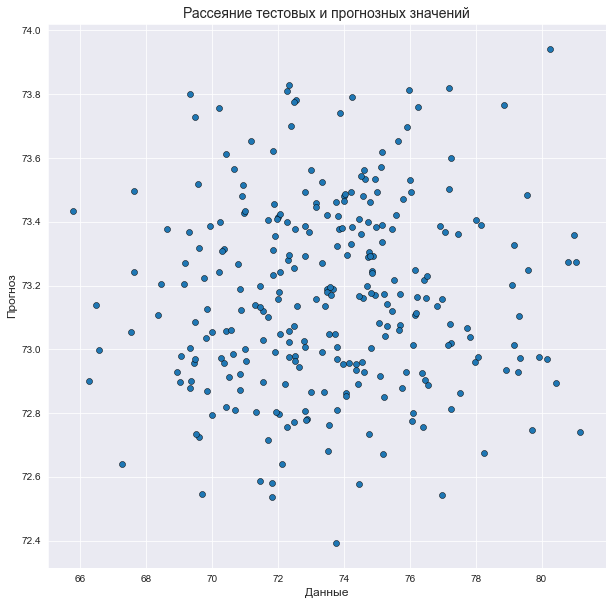

Данные    Прогноз
0    72.076773  73.048322
1    75.309657  73.074724
2    72.501611  73.256052
3    72.124020  72.639594
4    72.351939  73.022872
..         ...        ...
272  77.256415  73.600548
273  70.221071  73.242249
274  74.782273  73.293516
275  71.934726  72.802767
276  79.568781  73.485564

[277 rows x 2 columns]

In [196]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict111 = model_base111.predict(Xtest111)
predict111_values = np.ravel(predict111)
#Тестовые данные
tv111 = Ytest111.copy()
test111_values = np.ravel(tv111)
#Преобразуем нормализованные данные к исходным
col111 = ["Модуль упругости при растяжении, ГПа"]
#Определим параметры, которые использовались для нормализации
min111 = np.min(df[col111])
max111 = np.max(df[col111])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict111_values):
    predict111_values[i] = predict111_values[i]*(max111 - min111) + min111
    test111_values[i] = test111_values[i]*(max111 - min111) + min111
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results111 = pd.DataFrame({'Данные': test111_values,'Прогноз': predict111_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results111, edgecolor='black', palette='cubehelix')
plt.show()
feature_results111

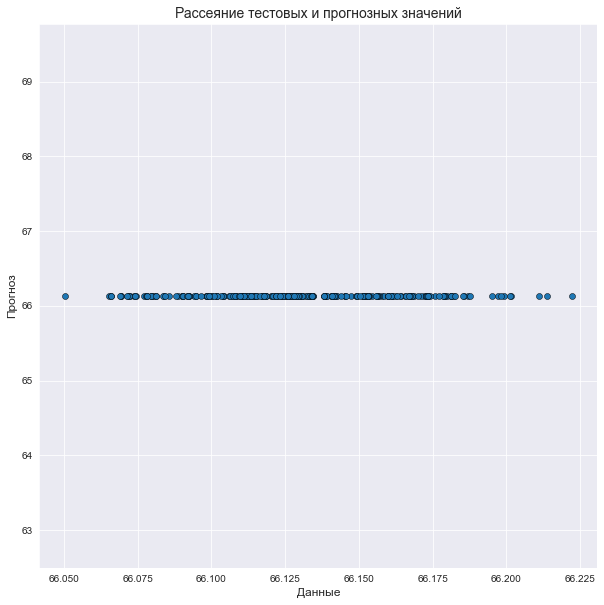

Данные    Прогноз
0    66.123800  66.132373
1    66.151416  66.132373
2    66.167024  66.132373
3    66.161214  66.132373
4    66.173399  66.132373
..         ...        ...
247  66.126000  66.132373
248  66.150265  66.132373
249  66.081114  66.132373
250  66.201315  66.132373
251  66.123064  66.132373

[252 rows x 2 columns]

In [197]:
plt.figure(figsize=(10, 10))
#Спрогнозированные данные
predict222 = model_base222.predict(Xtest222)
predict222_values = np.ravel(predict222)
#Тестовые данные
tv222 = Ytest222.copy()
test222_values = np.ravel(tv222)
#Преобразуем нормализованные данные к исходным
col222 = ["Модуль упругости при растяжении, ГПа"]
#Определим параметры, которые использовались для нормализации
min222 = np.min(df[col222])
max222 = np.max(df[col222])
#Сделаем преобразование, обратное нормализации (для нормализации использовался MinMaxScaler от 0 до 1)
i = 0
while i < len(predict222_values):
    predict222_values[i] = predict222_values[i]*(max222 - min222) + min222
    test222_values[i] = test222_values[i]*(max222 - min222) + min222
    i += 1
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results222 = pd.DataFrame({'Данные': test222_values,'Прогноз': predict222_values})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results222, edgecolor='black', palette='cubehelix')
plt.show()
feature_results222

In [198]:
df.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                       922.000000        922.000000   
mean                          2.927964       1974.118744   
std                           0.895472         71.040648   
min                           0.547391       1784.482245   
25%                           2.320191       1923.318006   
50%                           2.907832       1977.321002   
75%                           3.549367       2020.053266   
max                           5.314144       2161.565216   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count             922.000000                   922.000000   
mean              736.119982                   111.136066   
std               327.607008                    26.753228   
min                 2.436909                    38.668500   
25%               498.538615                    92.856591   
50%               736.178435                   111.162090   
75%               956.955626                   130.109815   
max              1628.000000                   181.828448   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                       922.000000                922.000000   
mean                         22.200570                286.181128   
std                           2.393926                 39.420764   
min                          15.695894                179.374391   
25%                          20.556328                259.205321   
50%                          22.177681                286.220763   
75%                          23.956980                313.012786   
max                          28.955094                386.067992   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                     922.000000                            922.000000   
mean                      482.429070                             73.303464   
std                       280.437329                              3.025864   
min                         0.603740                             65.793845   
25%                       264.345872                             71.241213   
50%                       457.732246                             73.247594   
75%                       695.531920                             75.310130   
max                      1291.340115                             81.203147   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                     922.000000               922.000000   
mean                     2461.491315               218.048059   
std                       453.564734                57.137475   
min                      1250.392802                72.530873   
25%                      2148.175736               179.875097   
50%                      2455.974462               218.697660   
75%                      2751.233766               256.623860   
max                      3654.434359               359.052220   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count          922.000000   922.000000         922.000000  
mean            45.976139     6.931939          57.562887  
std             45.013829     2.514184          11.122204  
min              0.000000     0.037639          28.661632  
25%              0.000000     5.143644          50.275385  
50%             90.000000     6.972862          57.584225  
75%             90.000000     8.612094          64.840898  
max             90.000000    13.732404          86.012427

In [199]:
df_norm_n.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                       837.000000        837.000000   
mean                          0.000868          0.587569   
std                           0.000275          0.056993   
min                           0.000163          0.444650   
25%                           0.000679          0.548948   
50%                           0.000857          0.585227   
75%                           0.001052          0.626059   
max                           0.001593          0.743130   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count             837.000000                   837.000000   
mean                0.216978                     0.032887   
std                 0.092124                     0.008474   
min                 0.000709                     0.011339   
25%                 0.151021                     0.027292   
50%                 0.219229                     0.032910   
75%                 0.280808                     0.038817   
max                 0.476145                     0.055088   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                       837.000000                837.000000   
mean                          0.006601                  0.085021   
std                           0.000926                  0.014082   
min                           0.004113                  0.049402   
25%                           0.005925                  0.075135   
50%                           0.006589                  0.083934   
75%                           0.007208                  0.094452   
max                           0.009122                  0.123083   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                     837.000000                            837.000000   
mean                        0.142062                              0.021821   
std                         0.081065                              0.002203   
min                         0.001902                              0.016105   
25%                         0.078825                              0.020292   
50%                         0.138593                              0.021720   
75%                         0.199600                              0.023319   
max                         0.368343                              0.027834   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                     837.000000               837.000000   
mean                        0.742763                 0.064855   
std                         0.056655                 0.017766   
min                         0.590461                 0.021630   
25%                         0.706068                 0.052063   
50%                         0.747345                 0.064468   
75%                         0.782554                 0.076808   
max                         0.877580                 0.114133   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count          837.000000   837.000000         837.000000  
mean             0.013891     0.002028           0.017140  
std              0.013515     0.000760           0.003525  
min              0.000000     0.000011           0.008164  
25%              0.000000     0.001505           0.014780  
50%              0.022461     0.002013           0.017152  
75%              0.026792     0.002523           0.019443  
max              0.034285     0.003983           0.026496

In [200]:
df_minmax_n.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                       922.000000        922.000000   
mean                          0.499412          0.502904   
std                           0.187858          0.188395   
min                           0.000000          0.000000   
25%                           0.371909          0.368184   
50%                           0.495189          0.511396   
75%                           0.629774          0.624719   
max                           1.000000          1.000000   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count             922.000000                   922.000000   
mean                0.451341                     0.506200   
std                 0.201534                     0.186876   
min                 0.000000                     0.000000   
25%                 0.305188                     0.378514   
50%                 0.451377                     0.506382   
75%                 0.587193                     0.638735   
max                 1.000000                     1.000000   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                       922.000000                922.000000   
mean                          0.490578                  0.516739   
std                           0.180548                  0.190721   
min                           0.000000                  0.000000   
25%                           0.366571                  0.386228   
50%                           0.488852                  0.516931   
75%                           0.623046                  0.646553   
max                           1.000000                  1.000000   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                     922.000000                            922.000000   
mean                        0.373295                              0.487343   
std                         0.217269                              0.196366   
min                         0.000000                              0.000000   
25%                         0.204335                              0.353512   
50%                         0.354161                              0.483718   
75%                         0.538397                              0.617568   
max                         1.000000                              1.000000   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                     922.000000               922.000000   
mean                        0.503776                 0.507876   
std                         0.188668                 0.199418   
min                         0.000000                 0.000000   
25%                         0.373447                 0.374647   
50%                         0.501481                 0.510143   
75%                         0.624299                 0.642511   
max                         1.000000                 1.000000   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count          922.000000   922.000000         922.000000  
mean             0.510846     0.503426           0.503938  
std              0.500154     0.183587           0.193933  
min              0.000000     0.000000           0.000000  
25%              0.000000     0.372844           0.376869  
50%              1.000000     0.506414           0.504310  
75%              1.000000     0.626112           0.630842  
max              1.000000     1.000000           1.000000

### Создаем нейронную сеть

In [201]:
df_NN = df.copy()

In [202]:
df_NN.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
1                         1.857143            2030.0             738.736842   
3                         1.857143            2030.0             738.736842   
4                         2.771331            2030.0             753.000000   
5                         2.767918            2000.0             748.000000   
6                         2.569620            1910.0             807.000000   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
1                        50.00                        23.750000   
3                       129.00                        21.250000   
4                       111.86                        22.267857   
5                       111.86                        22.267857   
6                       111.86                        22.267857   

   Температура вспышки, С_2  Поверхностная плотность, г/м2  \
1                284.615385                          210.0   
3                300.000000                          210.0   
4                284.615385                          210.0   
5                284.615385                          210.0   
6                284.615385                          210.0   

   Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
1                                  70.0                         3000.0   
3                                  70.0                         3000.0   
4                                  70.0                         3000.0   
5                                  70.0                         3000.0   
6                                  70.0                         3000.0   

   Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  Плотность нашивки  
1                    220.0                 0.0          4.0               60.0  
3                    220.0                 0.0          5.0               47.0  
4                    220.0                 0.0          5.0               57.0  
5                    220.0                 0.0          5.0               60.0  
6                    220.0                 0.0          5.0               70.0

In [203]:
X1 = df_minmax_n.copy()
y1 = X1.pop('Соотношение матрица-наполнитель')

X2 = df_norm_n.copy()
y2 = X2.pop('Соотношение матрица-наполнитель')

In [204]:
y1

0      0.274768
1      0.274768
2      0.466552
3      0.465836
4      0.424236
         ...   
917    0.361662
918    0.607674
919    0.573391
920    0.662497
921    0.684036
Name: Соотношение матрица-наполнитель, Length: 922, dtype: float64

In [205]:
y2

0      0.000499
1      0.000499
2      0.000744
3      0.000746
4      0.000699
         ...   
917    0.000700
918    0.001078
919    0.000953
920    0.001191
921    0.001071
Name: Соотношение матрица-наполнитель, Length: 837, dtype: float64

In [206]:
X1

Плотность, кг/м3  модуль упругости, ГПа  Количество отвердителя, м.%  \
0            0.651097               0.452951                     0.079153   
1            0.651097               0.452951                     0.630983   
2            0.651097               0.461725                     0.511257   
3            0.571539               0.458649                     0.511257   
4            0.332865               0.494944                     0.511257   
..                ...                    ...                          ...   
917          0.444480               0.560064                     0.337550   
918          0.704373               0.272088                     0.749605   
919          0.498274               0.254927                     0.501991   
920          0.748688               0.454635                     0.717585   
921          0.280923               0.255222                     0.632264   

     Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                           0.607435                  0.509164   
1                           0.418887                  0.583596   
2                           0.495653                  0.509164   
3                           0.495653                  0.509164   
4                           0.495653                  0.509164   
..                               ...                       ...   
917                         0.333908                  0.703458   
918                         0.294428                  0.362087   
919                         0.623085                  0.334063   
920                         0.267818                  0.466417   
921                         0.888354                  0.588206   

     Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                         0.162230                              0.272962   
1                         0.162230                              0.272962   
2                         0.162230                              0.272962   
3                         0.162230                              0.272962   
4                         0.162230                              0.272962   
..                             ...                                   ...   
917                       0.161609                              0.473553   
918                       0.271207                              0.462512   
919                       0.572959                              0.580201   
920                       0.496511                              0.535317   
921                       0.587373                              0.552644   

     Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0                         0.727777                 0.514688   
1                         0.727777                 0.514688   
2                         0.727777                 0.514688   
3                         0.727777                 0.514688   
4                         0.727777                 0.514688   
..                             ...                      ...   
917                       0.472912                 0.183151   
918                       0.461722                 0.157752   
919                       0.587558                 0.572648   
920                       0.341643                 0.434855   
921                       0.668015                 0.426577   

     Угол нашивки, град  Шаг нашивки  Плотность нашивки  
0                   0.0     0.289334           0.546433  
1                   0.0     0.362355           0.319758  
2                   0.0     0.362355           0.494123  
3                   0.0     0.362355           0.546433  
4                   0.0     0.362355           0.720799  
..                  ...          ...                ...  
917                 1.0     0.660014           0.320103  
918                 1.0     0.768759           0.437468  
919                 1.0     0.301102           0.679468  
920                 1.0     0.458245 

In [207]:
X2

Плотность, кг/м3  модуль упругости, ГПа  Количество отвердителя, м.%  \
0            0.545436               0.198490                     0.013434   
1            0.545011               0.198335                     0.034634   
2            0.544829               0.202097                     0.030022   
3            0.539271               0.201687                     0.030161   
4            0.519919               0.219673                     0.030449   
..                ...                    ...                          ...   
917          0.601520               0.281289                     0.026806   
918          0.641541               0.139172                     0.045683   
919          0.572927               0.121081                     0.032107   
920          0.664389               0.238353                     0.045454   
921          0.531558               0.117343                     0.036325   

     Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                           0.006381                  0.076473   
1                           0.005705                  0.080543   
2                           0.005976                  0.076388   
3                           0.006004                  0.076742   
4                           0.006062                  0.077475   
..                               ...                       ...   
917                         0.006201                  0.100077   
918                         0.006133                  0.079552   
919                         0.006959                  0.072161   
920                         0.006187                  0.088652   
921                         0.007726                  0.084624   

     Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                         0.056424                              0.018808   
1                         0.056380                              0.018793   
2                         0.056362                              0.018787   
3                         0.056623                              0.018874   
4                         0.057164                              0.019055   
..                             ...                                   ...   
917                       0.064463                              0.022522   
918                       0.109733                              0.022819   
919                       0.214994                              0.021709   
920                       0.206205                              0.023802   
921                       0.213349                              0.020895   

     Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0                         0.806064                 0.059111   
1                         0.805435                 0.059065   
2                         0.805167                 0.059046   
3                         0.808906                 0.059320   
4                         0.816627                 0.059886   
..                             ...                      ...   
917                       0.735625                 0.038520   
918                       0.738645                 0.036842   
919                       0.773510                 0.068729   
920                       0.665970                 0.063368   
921                       0.803159                 0.054762   

     Угол нашивки, град  Шаг нашивки  Плотность нашивки  
0              0.000000     0.001075           0.016121  
1              0.000000     0.001342           0.012618  
2              0.000000     0.001342           0.015298  
3              0.000000     0.001348           0.016178  
4              0.000000     0.001361           0.019055  
..                  ...          ...                ...  
917            0.027733     0.002797           0.014489  
918            0.028164     0.003306           0.016820  
919            0.026143     0.001209           0.019645  
920            0.028931     0.002029 

In [208]:
#Разбиваем выборку на тестировочную, валидационную и тестовую часть
#Случайное распределение начинается с 1 , чтобы не было совсем случайным

X1_train_val, X1_test, y1_train_val, y1_test = train_test_split(X1, y1, test_size=0.3)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train_val, y1_train_val, test_size=0.3)

X2_train_val, X2_test, y2_train_val, y2_test = train_test_split(X2, y2, test_size=0.3)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train_val, y2_train_val, test_size=0.3)

In [209]:
X1trn1, X1test1, Y1trn1, Y1test1 = train_test_split(X1, y1, test_size=0.3)
X1trn2, X1test2, Y1trn2, Y1test2 = train_test_split(X1, y1, test_size=0.3)
X1trn3, X1test3, Y1trn3, Y1test3 = train_test_split(X1, y1, test_size=0.3)

X2trn1, X2test1, Y2trn1, Y2test1 = train_test_split(X2, y2, test_size=0.3)
X2trn2, X2test2, Y2trn2, Y2test2 = train_test_split(X2, y2, test_size=0.3)
X2trn3, X2test3, Y2trn3, Y2test3 = train_test_split(X2, y2, test_size=0.3)

In [210]:
X1test2

Плотность, кг/м3  модуль упругости, ГПа  Количество отвердителя, м.%  \
68           0.714554               0.435797                     0.672598   
209          0.185062               0.208168                     0.419356   
735          0.796750               0.212854                     0.639823   
367          0.626775               0.567330                     0.349397   
335          0.158582               0.593573                     0.199072   
..                ...                    ...                          ...   
377          0.572051               0.460766                     0.648652   
526          0.931898               0.431804                     0.204022   
136          0.564147               0.620307                     0.481147   
652          0.582417               0.386686                     0.133749   
152          0.603761               0.571833                     0.346934   

     Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
68                          0.485290                  0.606979   
209                         0.556450                  0.517467   
735                         0.375182                  0.842704   
367                         0.686805                  0.548359   
335                         0.026629                  0.517354   
..                               ...                       ...   
377                         0.491174                  0.503444   
526                         0.496738                  0.318259   
136                         0.121021                  0.692610   
652                         0.531192                  0.312489   
152                         0.213822                  0.423409   

     Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
68                        0.279300                              0.405833   
209                       0.347406                              0.568498   
735                       0.238743                              0.666269   
367                       0.492922                              0.240023   
335                       0.298155                              0.346319   
..                             ...                                   ...   
377                       0.056423                              0.742719   
526                       0.408733                              0.366970   
136                       0.127634                              0.453108   
652                       0.567000                              0.441792   
152                       0.054758                              0.562064   

     Прочность при растяжении, МПа  Потребление смолы, г/м2  \
68                        0.645490                 0.564279   
209                       0.707604                 0.610741   
735                       0.366049                 0.116771   
367                       0.228407                 0.464501   
335                       0.294067                 0.631676   
..                             ...                      ...   
377                       0.605408                 0.528535   
526                       0.808443                 0.743006   
136                       0.372081                 0.305683   
652                       0.284249                 0.553320   
152                       0.729339                 0.620308   

     Угол нашивки, град  Шаг нашивки  Плотность нашивки  
68                  0.0     0.330843           0.418110  
209                 0.0     0.590163           0.486607  
735                 1.0     0.326730           0.736446  
367                 0.0     0.385381           0.476759  
335                 0.0     0.373634           0.849055  
..                  ...          ...                ...  
377                 0.0     0.536400           0.710983  
526                 1.0     0.248579           0.583466  
136                 0.0     0.549097           0.524335  
652                 1.0     0.325623 

In [211]:
def plot_loss(history, y_max):
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, y_max])
    plt.xlabel('Эпоха')
    plt.ylabel('MAE [Соотношение матрица-наполнитель]')
    plt.legend()
    plt.grid(True)

In [212]:
from keras import models
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

In [214]:
def build_model1():
    model1=models.Sequential()
    model1.add(layers.Dense(64, activation='tanh', input_shape=(X1trn1.shape[1],)))
    model1.add(layers.Dense(64, activation='tanh'))
    model1.add(layers.Dense(1))
    model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model1

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


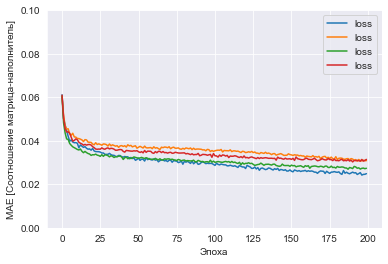

In [217]:
k = 4
num_val_samples1 = len(X1trn1) // k
num_epochs1 = 200
all_scores1 = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data1 = X1trn1[i * num_val_samples1: (i + 1) * num_val_samples1]
    val_targets1 = Y1trn1[i * num_val_samples1: (i + 1) * num_val_samples1]
# Prepare the training data: data from all other partitions
    partial_train_data1 = np.concatenate(
        [X1trn1[:i * num_val_samples1],
         X1trn1[(i + 1) * num_val_samples1:]],
        axis=0)
    partial_train_targets1 = np.concatenate(
        [Y1trn1[:i * num_val_samples1],
         Y1trn1[(i + 1) * num_val_samples1:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model1 = build_model1()
    # Train the model (in silent mode, verbose=0)
    history1 = model1.fit(partial_train_data1, partial_train_targets1,
                  epochs=num_epochs1, batch_size=1, verbose=0)
    plot_loss(history1,0.1)
    # Evaluate the model on the validation data
    val_mse1, val_mae1 = model1.evaluate(val_data1, val_targets1, verbose=0)
    all_scores1.append(val_mae1)

In [218]:
predict1 = model1.predict(X1test1)

In [219]:
all_scores1

[0.18905894458293915,
 0.14951787889003754,
 0.18391068279743195,
 0.1624741405248642]

In [220]:
np.mean(all_scores1)

0.1712404116988182

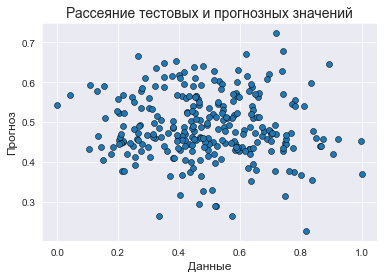

Данные   Прогноз
0    0.439831  0.501854
1    0.638328  0.539216
2    0.274799  0.427661
3    0.381253  0.410576
4    0.455313  0.564241
..        ...       ...
272  0.648514  0.571335
273  0.419445  0.405875
274  0.341934  0.505846
275  0.526656  0.550951
276  0.590948  0.601100

[277 rows x 2 columns]

In [221]:
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results1 = pd.DataFrame({'Данные': Y1test1.to_numpy(),'Прогноз': predict1.reshape(len(predict1))})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results1, edgecolor='black', palette='cubehelix')
plt.show()
feature_results1

In [222]:
def build_model12():
    model12=models.Sequential()
    model12.add(layers.Dense(64, activation='tanh', input_shape=(X1trn2.shape[1],)))
    model12.add(layers.Dense(64, activation='tanh'))
    model12.add(layers.Dense(1))
    model12.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model12

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


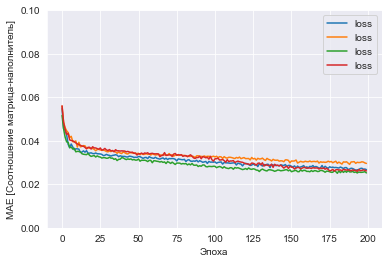

In [225]:
k2 = 4
num_val_samples12 = len(X1trn2) // k2
num_epochs12 = 200
all_scores12 = []
for i2 in range(k2):
    print('processing fold #', i2)
    # Prepare the validation data: data from partition # k
    val_data12 = X1trn2[i2 * num_val_samples12: (i2 + 1) * num_val_samples12]
    val_targets12 = Y1trn2[i2 * num_val_samples12: (i2 + 1) * num_val_samples12]
# Prepare the training data: data from all other partitions
    partial_train_data12 = np.concatenate(
        [X1trn2[:i2 * num_val_samples12],
         X1trn2[(i2 + 1) * num_val_samples12:]],
        axis=0)
    partial_train_targets12 = np.concatenate(
        [Y1trn2[:i2 * num_val_samples12],
         Y1trn2[(i2 + 1) * num_val_samples12:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model12 = build_model12()
    # Train the model (in silent mode, verbose=0)
    history12 = model12.fit(partial_train_data12, partial_train_targets12,
                  epochs=num_epochs12, batch_size=1, verbose=0)
    plot_loss(history12,0.1)
    # Evaluate the model on the validation data
    val_mse12, val_mae12 = model12.evaluate(val_data12, val_targets12, verbose=0)
    all_scores12.append(val_mae12)

In [227]:
predict12 = model12.predict(X1test2)

In [248]:
all_scores12

[0.18138600885868073,
 0.15812675654888153,
 0.17748667299747467,
 0.16110657155513763]

In [249]:
np.mean(all_scores12)

0.16952650249004364

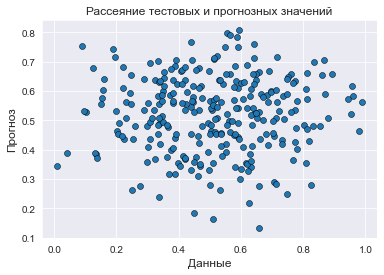

Данные   Прогноз
0    0.387258  0.438928
1    0.588735  0.784112
2    0.504202  0.463572
3    0.528359  0.638538
4    0.505854  0.534838
..        ...       ...
272  0.739697  0.503467
273  0.524701  0.544280
274  0.198417  0.533502
275  0.409386  0.625002
276  0.748254  0.639669

[277 rows x 2 columns]

In [250]:
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results12 = pd.DataFrame({'Данные': Y1test2.to_numpy(),'Прогноз': predict12.reshape(len(predict12))})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=12)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results12, edgecolor='black', palette='cubehelix')
plt.show()
feature_results12

In [229]:
def build_model13():
    model13=models.Sequential()
    model13.add(layers.Dense(64, activation='sigmoid', input_shape=(X1trn3.shape[1],)))
    model13.add(layers.Dense(64, activation='sigmoid'))
    model13.add(layers.Dense(1))
    model13.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model13

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


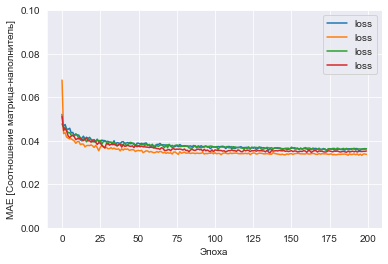

In [232]:
k3 = 4
num_val_samples13 = len(X1trn3) // k3
num_epochs13 = 200
all_scores13 = []
for i3 in range(k3):
    print('processing fold #', i3)
    # Prepare the validation data: data from partition # k
    val_data13 = X1trn3[i3 * num_val_samples13: (i3 + 1) * num_val_samples13]
    val_targets13 = Y1trn3[i3 * num_val_samples13: (i3 + 1) * num_val_samples13]
# Prepare the training data: data from all other partitions
    partial_train_data13 = np.concatenate(
        [X1trn3[:i3 * num_val_samples13],
         X1trn3[(i3 + 1) * num_val_samples13:]],
        axis=0)
    partial_train_targets13 = np.concatenate(
        [Y1trn3[:i3 * num_val_samples13],
         Y1trn3[(i3 + 1) * num_val_samples13:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model13 = build_model13()
    # Train the model (in silent mode, verbose=0)
    history13 = model13.fit(partial_train_data13, partial_train_targets13,
                  epochs=num_epochs13, batch_size=1, verbose=0)
    plot_loss(history13,0.1)
    # Evaluate the model on the validation data
    val_mse13, val_mae13 = model13.evaluate(val_data13, val_targets13, verbose=0)
    all_scores13.append(val_mae13)

In [233]:
predict13 = model13.predict(X1test3)

In [244]:
all_scores13

[0.14999693632125854,
 0.16233162581920624,
 0.14788849651813507,
 0.1549447923898697]

In [246]:
np.mean(all_scores13)

0.15379046276211739

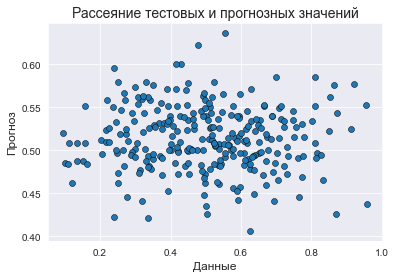

Данные   Прогноз
0    0.319138  0.441282
1    0.366300  0.531129
2    0.397774  0.540102
3    0.722423  0.481907
4    0.666214  0.550901
..        ...       ...
272  0.589733  0.510593
273  0.494837  0.467828
274  0.223971  0.509313
275  0.298759  0.492468
276  0.555986  0.496744

[277 rows x 2 columns]

In [247]:
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results13 = pd.DataFrame({'Данные': Y1test3.to_numpy(),'Прогноз': predict13.reshape(len(predict13))})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results13, edgecolor='black', palette='cubehelix')
plt.show()
feature_results13

In [235]:
#X2trn1, X2test1, Y2trn1, Y2test1 = train_test_split(X2, y2, test_size=0.3)
#X2trn2, X2test2, Y2trn2, Y2test2 = train_test_split(X2, y2, test_size=0.3)
#X2trn3, X2test3, Y2trn3, Y2test3 = train_test_split(X2, y2, test_size=0.3)

In [236]:
X2test2

Плотность, кг/м3  модуль упругости, ГПа  Количество отвердителя, м.%  \
54           0.674683               0.085216                     0.034892   
700          0.632106               0.112527                     0.035444   
496          0.616538               0.356741                     0.034144   
320          0.644112               0.224338                     0.037444   
655          0.549309               0.163637                     0.039427   
..                ...                    ...                          ...   
132          0.509015               0.171998                     0.014731   
412          0.513346               0.139478                     0.022115   
287          0.638818               0.100010                     0.040063   
193          0.616450               0.340459                     0.028111   
779          0.619214               0.390426                     0.021188   

     Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
54                          0.006674                  0.098817   
700                         0.007824                  0.096256   
496                         0.006660                  0.076159   
320                         0.006570                  0.074284   
655                         0.004984                  0.078286   
..                               ...                       ...   
132                         0.006596                  0.064845   
412                         0.005101                  0.087506   
287                         0.007761                  0.116815   
193                         0.007055                  0.081345   
779                         0.006410                  0.065316   

     Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
54                        0.137058                              0.023390   
700                       0.086362                              0.024473   
496                       0.187150                              0.021964   
320                       0.069644                              0.023854   
655                       0.125193                              0.020755   
..                             ...                                   ...   
132                       0.029361                              0.019576   
412                       0.232451                              0.019526   
287                       0.268787                              0.021413   
193                       0.251889                              0.023068   
779                       0.080802                              0.021275   

     Прочность при растяжении, МПа  Потребление смолы, г/м2  \
54                        0.704775                 0.100024   
700                       0.751284                 0.058078   
496                       0.664119                 0.087659   
320                       0.718380                 0.075691   
655                       0.800179                 0.080423   
..                             ...                      ...   
132                       0.835765                 0.082121   
412                       0.804892                 0.080021   
287                       0.701122                 0.043739   
193                       0.654146                 0.066547   
779                       0.670133                 0.048746   

     Угол нашивки, град  Шаг нашивки  Плотность нашивки  
54             0.000000     0.000757           0.021622  
700            0.029893     0.002751           0.020918  
496            0.028315     0.002272           0.023497  
320            0.000000     0.001855           0.024619  
655            0.024190     0.001824           0.018096  
..                  ...          ...                ...  
132            0.000000     0.001104           0.018971  
412            0.000000     0.001895           0.013255  
287            0.000000     0.002173           0.020052  
193            0.000000     0.000047 

In [237]:
def build_model21():
    model21=models.Sequential()
    model21.add(layers.Dense(64, activation='tanh', input_shape=(X2trn1.shape[1],)))
    model21.add(layers.Dense(64, activation='tanh'))
    model21.add(layers.Dense(1))
    model21.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model21

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


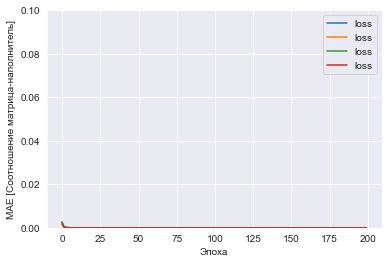

In [238]:
k = 4
num_val_samples21 = len(X1trn1) // k
num_epochs21 = 200
all_scores21 = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data21 = X2trn1[i * num_val_samples21: (i + 1) * num_val_samples21]
    val_targets21 = Y2trn1[i * num_val_samples12: (i + 1) * num_val_samples21]
# Prepare the training data: data from all other partitions
    partial_train_data21 = np.concatenate(
        [X2trn1[:i * num_val_samples21],
         X2trn1[(i + 1) * num_val_samples21:]],
        axis=0)
    partial_train_targets21 = np.concatenate(
        [Y2trn1[:i * num_val_samples21],
         Y2trn1[(i + 1) * num_val_samples21:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model21 = build_model21()
    # Train the model (in silent mode, verbose=0)
    history21 = model21.fit(partial_train_data21, partial_train_targets21,
                  epochs=num_epochs21, batch_size=1, verbose=0)
    plot_loss(history21,0.1)
    # Evaluate the model on the validation data
    val_mse21, val_mae21 = model21.evaluate(val_data21, val_targets21, verbose=0)
    all_scores21.append(val_mae21)

In [239]:
predict21 = model21.predict(X2test1)

In [241]:
all_scores21

[0.00039395870408043265,
 0.000518019194714725,
 0.00038435717578977346,
 0.0003645074903033674]

In [242]:
np.mean(all_scores21)

0.00041521064122207463

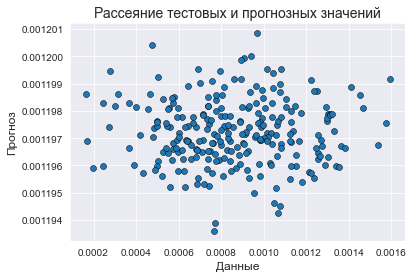

Данные   Прогноз
0    0.000658  0.001196
1    0.000925  0.001197
2    0.000365  0.001198
3    0.001363  0.001197
4    0.000635  0.001197
..        ...       ...
247  0.001078  0.001199
248  0.001220  0.001196
249  0.001266  0.001196
250  0.000604  0.001197
251  0.000739  0.001198

[252 rows x 2 columns]

In [243]:
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results21 = pd.DataFrame({'Данные': Y2test1.to_numpy(),'Прогноз': predict21.reshape(len(predict21))})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results21, edgecolor='black', palette='cubehelix')
plt.show()
feature_results21

In [251]:
def build_model22():
    model22=models.Sequential()
    model22.add(layers.Dense(64, activation='tanh', input_shape=(X2trn2.shape[1],)))
    model22.add(layers.Dense(64, activation='tanh'))
    model22.add(layers.Dense(1))
    model22.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model22

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


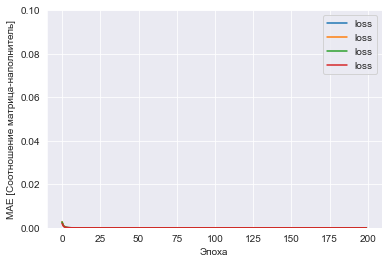

In [254]:
k2 = 4
num_val_samples22 = len(X2trn2) // k2
num_epochs22 = 200
all_scores22 = []
for i2 in range(k2):
    print('processing fold #', i2)
    # Prepare the validation data: data from partition # k
    val_data22 = X2trn2[i2 * num_val_samples22: (i2 + 1) * num_val_samples22]
    val_targets22 = Y2trn2[i2 * num_val_samples22: (i2 + 1) * num_val_samples22]
# Prepare the training data: data from all other partitions
    partial_train_data22 = np.concatenate(
        [X2trn2[:i2 * num_val_samples22],
         X2trn2[(i2 + 1) * num_val_samples22:]],
        axis=0)
    partial_train_targets22 = np.concatenate(
        [Y2trn2[:i2 * num_val_samples22],
         Y2trn2[(i2 + 1) * num_val_samples22:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model22 = build_model22()
    # Train the model (in silent mode, verbose=0)
    history22 = model22.fit(partial_train_data22, partial_train_targets22,
                  epochs=num_epochs22, batch_size=1, verbose=0)
    plot_loss(history22,0.1)
    # Evaluate the model on the validation data
    val_mse22, val_mae22 = model22.evaluate(val_data22, val_targets22, verbose=0)
    all_scores22.append(val_mae22)

In [255]:
predict22 = model22.predict(X2test2)

In [256]:
all_scores22

[0.0003346882003825158,
 0.0008271291735582054,
 0.00024771798052825034,
 0.00022360881848726422]

In [257]:
np.mean(all_scores22)

0.0004082860432390589

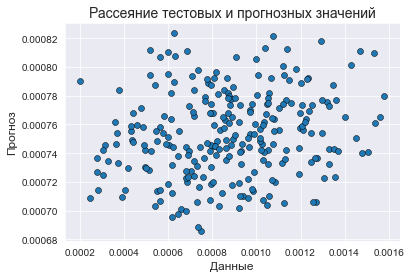

Данные   Прогноз
0    0.000879  0.000773
1    0.000893  0.000750
2    0.001236  0.000792
3    0.000794  0.000768
4    0.001193  0.000726
..        ...       ...
247  0.000789  0.000708
248  0.000920  0.000719
249  0.001071  0.000765
250  0.000809  0.000792
251  0.000795  0.000787

[252 rows x 2 columns]

In [263]:
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results22 = pd.DataFrame({'Данные': Y2test2.to_numpy(),'Прогноз': predict22.reshape(len(predict22))})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results22, edgecolor='black', palette='cubehelix')
plt.show()
feature_results22

In [261]:
def build_model33():
    model33=models.Sequential()
    model33.add(layers.Dense(64, activation='sigmoid', input_shape=(X2trn3.shape[1],)))
    model33.add(layers.Dense(64, activation='sigmoid'))
    model33.add(layers.Dense(1))
    model33.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model33

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


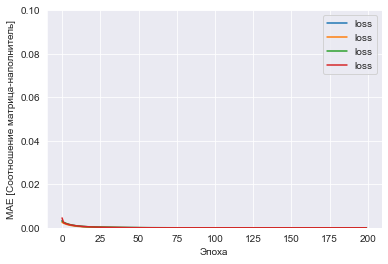

In [262]:
k2 = 4
num_val_samples33 = len(X2trn3) // k2
num_epochs33 = 200
all_scores33 = []
for i2 in range(k2):
    print('processing fold #', i2)
    # Prepare the validation data: data from partition # k
    val_data33 = X2trn2[i2 * num_val_samples33: (i2 + 1) * num_val_samples33]
    val_targets33 = Y2trn3[i2 * num_val_samples33: (i2 + 1) * num_val_samples33]
# Prepare the training data: data from all other partitions
    partial_train_data33 = np.concatenate(
        [X2trn3[:i2 * num_val_samples33],
         X2trn3[(i2 + 1) * num_val_samples33:]],
        axis=0)
    partial_train_targets33 = np.concatenate(
        [Y2trn3[:i2 * num_val_samples33],
         Y2trn3[(i2 + 1) * num_val_samples33:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model33 = build_model33()
    # Train the model (in silent mode, verbose=0)
    history33 = model33.fit(partial_train_data33, partial_train_targets33,
                  epochs=num_epochs33, batch_size=1, verbose=0)
    plot_loss(history33,0.1)
    # Evaluate the model on the validation data
    val_mse33, val_mae33 = model33.evaluate(val_data33, val_targets33, verbose=0)
    all_scores33.append(val_mae33)

In [264]:
predict33 = model33.predict(X2test3)

In [265]:
all_scores33

[0.0008295731386169791,
 0.0007019577315077186,
 0.002649577334523201,
 0.0005410686717368662]

In [266]:
np.mean(all_scores33)

0.0011805442190961912

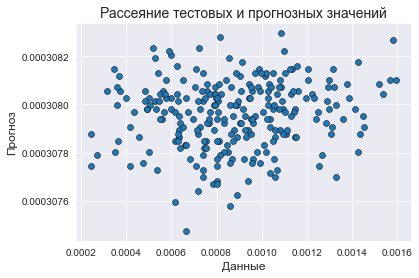

Данные   Прогноз
0    0.000769  0.000308
1    0.000913  0.000308
2    0.000870  0.000308
3    0.000893  0.000308
4    0.001195  0.000308
..        ...       ...
247  0.001415  0.000308
248  0.000862  0.000308
249  0.000573  0.000308
250  0.001319  0.000308
251  0.001451  0.000308

[252 rows x 2 columns]

In [267]:
#Создадим датасет с тестовыми данными и прогнозными значениями
feature_results33 = pd.DataFrame({'Данные': Y2test3.to_numpy(),'Прогноз': predict33.reshape(len(predict33))})
#Выведем график рассеяния. В случае идеального прогноза график походил бы на прямую
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=14)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results33, edgecolor='black', palette='cubehelix')
plt.show()
feature_results33

In [270]:
model1.save('Models/model11.h5')
model12.save('Models/model12.h5')
model13.save('Models/model13.h5')

model21.save('Models/model21.h5')
model22.save('Models/model22.h5')
model33.save('Models/model23.h5')

In [273]:
#Ввод данных пользователем user
user = df.copy(deep = True)
user = user.reset_index()
user = user.drop(labels=range(1, 922), axis=0)
user.drop(['index'], inplace=True, axis=1)

print('Введите параметры:') 
a = 0 
for i in df.columns: 
    if a != 0 and a != 7 and a !=8: 
        print(col[a]) 
        y = input() 
        user[col[a]].values[0] = float(y) 
    else: 
        user[col[a]].values[0] = 0 
    a+=1
    if a == 13:
        break

Введите параметры:
Плотность, кг/м3
0.1
модуль упругости, ГПа
0.8
Количество отвердителя, м.%
0.6
Содержание эпоксидных групп,%_2
0.04
Температура вспышки, С_2
0.9
Поверхностная плотность, г/м2
0.3
Потребление смолы, г/м2
0.07
Угол нашивки, град
1
Шаг нашивки
0.06
Плотность нашивки
0.7


In [274]:
user.drop('Соотношение матрица-наполнитель', inplace=True, axis=1)

In [275]:
user

Плотность, кг/м3  модуль упругости, ГПа  Количество отвердителя, м.%  \
0               0.1                    0.8                          0.6   

   Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                             0.04                       0.9   

   Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                            0.3                                   0.0   

   Прочность при растяжении, МПа  Потребление смолы, г/м2  Угол нашивки, град  \
0                            0.0                     0.07                 1.0   

   Шаг нашивки  Плотность нашивки  
0         0.06                0.7

In [276]:
pred11 = model1.predict(user)
pred12 = model12.predict(user)
pred13 = model13.predict(user)

pred21 = model21.predict(user)
pred22 = model22.predict(user)
pred23 = model33.predict(user)

In [277]:
print(pred11, pred12, pred13)
print('\n')
print(pred21, pred22, pred23)

[[0.45240209]] [[0.18375595]] [[0.426705]]


[[0.00119994]] [[0.0008333]] [[0.00031743]]


In [278]:
pred_inversed = pd.DataFrame([])
pred_inversed.at[0,0] = float(pred11)

for i in range(1, 13):
    p = 0
    pred_inversed.at[0,i] = float(p)
pred_inversed

0    1    2    3    4    5    6    7    8    9    10   11   12
0  0.452402  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [293]:
#Возвращает предсказанное значание (в размерности до нормализации)
Y_trans = df_std_X1.inverse_transform(pred_inversed)
Y_trans2 = df_std_X2.inverse_transform(pred_inversed)
print(Y_trans[0,0])
print(Y_trans2[0,0])

0.5843530482542842
0.0009918497554419698


In [294]:
df.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                       922.000000        922.000000   
mean                          2.927964       1974.118744   
std                           0.895472         71.040648   
min                           0.547391       1784.482245   
25%                           2.320191       1923.318006   
50%                           2.907832       1977.321002   
75%                           3.549367       2020.053266   
max                           5.314144       2161.565216   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count             922.000000                   922.000000   
mean              736.119982                   111.136066   
std               327.607008                    26.753228   
min                 2.436909                    38.668500   
25%               498.538615                    92.856591   
50%               736.178435                   111.162090   
75%               956.955626                   130.109815   
max              1628.000000                   181.828448   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                       922.000000                922.000000   
mean                         22.200570                286.181128   
std                           2.393926                 39.420764   
min                          15.695894                179.374391   
25%                          20.556328                259.205321   
50%                          22.177681                286.220763   
75%                          23.956980                313.012786   
max                          28.955094                386.067992   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                     922.000000                            922.000000   
mean                      482.429070                             73.303464   
std                       280.437329                              3.025864   
min                         0.603740                             65.793845   
25%                       264.345872                             71.241213   
50%                       457.732246                             73.247594   
75%                       695.531920                             75.310130   
max                      1291.340115                             81.203147   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                     922.000000               922.000000   
mean                     2461.491315               218.048059   
std                       453.564734                57.137475   
min                      1250.392802                72.530873   
25%                      2148.175736               179.875097   
50%                      2455.974462               218.697660   
75%                      2751.233766               256.623860   
max                      3654.434359               359.052220   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count          922.000000   922.000000         922.000000  
mean            45.976139     6.931939          57.562887  
std             45.013829     2.514184          11.122204  
min              0.000000     0.037639          28.661632  
25%              0.000000     5.143644          50.275385  
50%             90.000000     6.972862          57.584225  
75%             90.000000     8.612094          64.840898  
max             90.000000    13.732404          86.012427